In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/masters


In [6]:
%ls ./data/processed
# # T12H-X850M-Y880M_2013-01-01_2015-01-01/
# # T1H-X1700M-Y1760M_2013-01-01_2015-01-01/
# # T1H-X850M-Y880M_2013-01-01_2015-01-01/
# # T24H-X255M-Y220M_2013-01-01_2015-01-01/
# # T24H-X425M-Y440M_2013-01-01_2015-01-01/
# # T24H-X850M-Y880M_2013-01-01_2015-01-01/
# # T24H-X85M-Y110M_2013-01-01_2015-01-01/
# # T3H-X850M-Y880M_2013-01-01_2015-01-01/
# # T6H-X850M-Y880M_2013-01-01_2015-01-01/

T12H-X850M-Y880M_2013-01-01_2015-01-01/
T1H-X1700M-Y1760M_2013-01-01_2015-01-01/
T1H-X850M-Y880M_2013-01-01_2015-01-01/
T24H-X255M-Y220M_2013-01-01_2015-01-01/
T24H-X425M-Y440M_2013-01-01_2015-01-01/
T24H-X850M-Y880M_2013-01-01_2015-01-01/
T24H-X85M-Y110M_2013-01-01_2015-01-01/
T3H-X850M-Y880M_2013-01-01_2015-01-01/
T6H-X850M-Y880M_2013-01-01_2015-01-01/


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.metrics import best_threshold
from utils.utils import write_json, Timer
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, best_threshold, get_y_pred, \
                                get_y_pred_by_thresholds, best_thresholds
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from trainers.generic_trainer import train_model
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths
from models.model_result import save_metrics, compare_models,get_metrics_table, get_models_metrics, get_models_results
from models.st_resnet_models import STResNet, STResNetExtra
from models.st_resnet_models import train_epoch_for_st_res_net, train_epoch_for_st_res_net_extra
from models.st_resnet_models import evaluate_st_res_net, evaluate_st_res_net_extra

In [4]:
data_sub_paths = get_data_sub_paths()
data_sub_paths

['T24H-X85M-Y110M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T12H-X850M-Y880M_2013-01-01_2015-01-01',
 'T6H-X850M-Y880M_2013-01-01_2015-01-01',
 'T3H-X850M-Y880M_2013-01-01_2015-01-01']

## Load data

In [5]:
USE_EXTRA = False # todo move extra model to own notebook

start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = 'T24H-X255M-Y220M' # "T24H-X850M-Y880M" # "T1H-X1700M-Y1760M" #
conf = BaseConf()

if USE_EXTRA:
    conf.model_name = "ST-RESNET-Extra"  # needs to be created
else:     
    conf.model_name = "ST-RESNET"  # needs to be created

conf.data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path =  f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device


2019-11-12T08:25:19 | root | INFO | =====================================BEGIN=====================================
2019-11-12T08:25:19 | root | INFO | Device: cuda:0


In [6]:
conf.batch_size = 64

# CRIME DATA
data_group = GridDataGroup(data_path=conf.data_path,
                           conf=conf)

loaders = GridDataLoaders(data_group=data_group,
                          conf=conf)

2019-11-12T08:25:21 | root | INFO | 	t_range shape (731,)


## Model setup

In [0]:
# SET THE HYPER PARAMETERS
conf.dropout = 0#0.2
conf.weight_decay = 1e-8
conf.lr = 5e-4
conf.checkpoint =  "best" # "latest" # 
conf.resume = False
conf.freqstr = data_group.t_range.freqstr  
conf.early_stopping = False
conf.max_epochs = 10

# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
loss_function = nn.MSELoss()  

# SETUP MODEL
dataset = loaders.train_loader.dataset
_, h_size, w_size = dataset.crimes.shape
_, n_ext_features = dataset.time_vectors.shape


# todo setup - hyper-optimiser
conf.n_layers = 5  # number of res-unit layers
conf.n_channels = 3 # inner channel size of the res-units 

if USE_EXTRA:
    train_epoch_fn = train_epoch_for_st_res_net_extra
    evaluate_fn = evaluate_st_res_net_extra
    model = STResNetExtra(n_layers=conf.n_layers,
                          n_channels=conf.n_channels,
                          y_size=h_size,
                          x_size=w_size,

                          lc=dataset.n_steps_c,
                          lp=dataset.n_steps_p,
                          lq=dataset.n_steps_q,

                          n_ext_features=n_ext_features,
                          n_demog_features=37,
                          n_demog_channels=10,
                          n_demog_layers=3,

                          n_gsv_features=512,
                          n_gsv_channels=10,
                          n_gsv_layers=3)
else:
    train_epoch_fn = train_epoch_for_st_res_net
    evaluate_fn = evaluate_st_res_net
    model = STResNet(n_layers=conf.n_layers,
                     n_channels=conf.n_channels,
                     y_size=h_size,
                     x_size=w_size,

                     lc=dataset.n_steps_c,
                     lp=dataset.n_steps_p,
                     lq=dataset.n_steps_q,

                     n_ext_features=n_ext_features)    
    
# todo implement model_arch for res-net
model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()
# todo (optional): setup model parameters dynamically 

optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

if conf.resume:
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

        # new optimiser hyper-parameters
        optimiser.param_groups[0]['lr'] = conf.lr
        optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")


## Training loop

2019-11-12T08:25:32 | root | INFO | lr: 		0.001
2019-11-12T08:25:32 | root | INFO | weight_decay: 	1e-08
2019-11-12T08:25:32 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T08:25:32 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X255M-Y220M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.001,
 'max_epochs': 20,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T24H-X255M-Y220M_2013-01-01_2015-01-01/models/ST-RESNET/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 6,
 'resume': False,
 'seed': 3,
 'seq_len': 1,
 'shaper_threshold': 0,
 'shaper_top_k': -1,
 'shuffle': False,
 'sub_sample_test_set': 0,
 'sub_sample_train_set': 1,
 'sub_sample_validation_set': 

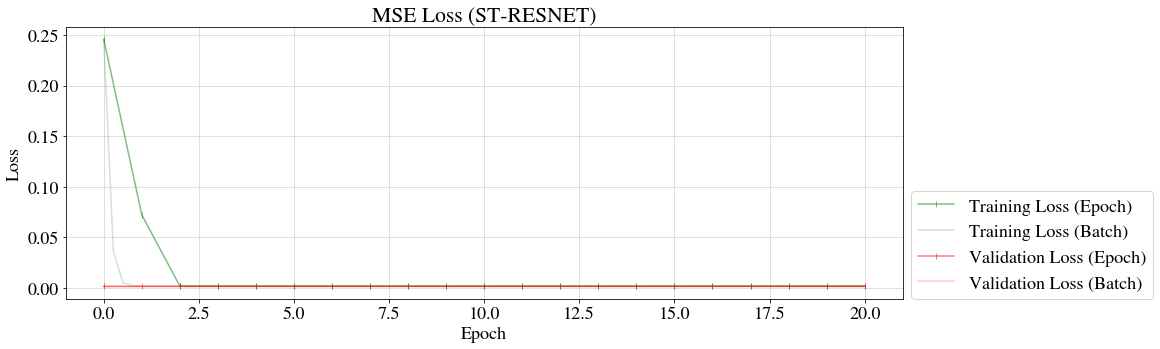

In [8]:
log.info(f"lr: \t\t{optimiser.param_groups[0]['lr']}")
log.info(f"weight_decay: \t{optimiser.param_groups[0]['weight_decay']}")
trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                           optimiser=optimiser,
                                           loaders=loaders,
                                           train_epoch_fn=train_epoch_fn,
                                           loss_fn=loss_function,
                                           conf=conf)    

print(f"stopped_early: {stopped_early}") # use the current epoch instead
# if stopped_early -> continue with best_model - new hyper-parameters -> no n 

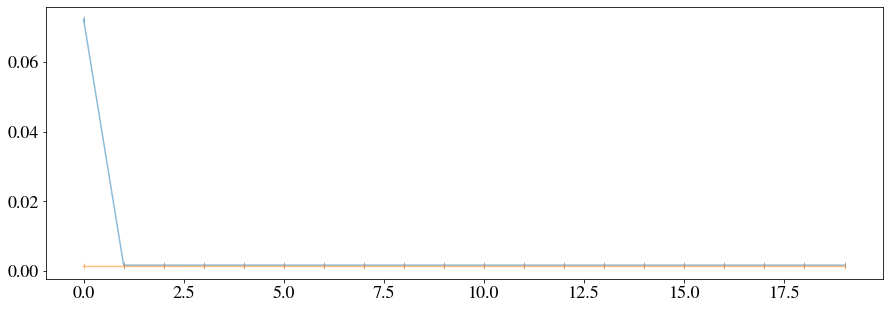

In [14]:
plt.figure(figsize=(15,5))
for x in [trn_epoch_losses, val_epoch_losses]:
    plt.plot(x[-5:],marker='|',alpha=.5)
plt.show()


## Evaluation

In [15]:
# Load latest or best validation model
# conf.checkpoint = "latest"
conf.checkpoint = "best"

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validaton score checkpoint
# load model state
log.info(f"loading model from {conf.model_path}")
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                map_location=conf.device.type)
model.load_state_dict(model_state_dict)


2019-11-12T08:40:18 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T08:40:18 | root | INFO | loading model from ./data/processed/T24H-X255M-Y220M_2013-01-01_2015-01-01/models/ST-RESNET/


<All keys matched successfully>

2019-11-12T08:40:32 | root | INFO | f1_score: 0.1508734662678926 at index 911916, new threshold 0.012228545732796192
2019-11-12T08:40:35 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.6220348896352105                
                Average Precision:  0.17140482687405587
                Precision:          0.1943143180959577
                Recall:             0.24137121940918368
                Accuracy:           0.8465199103496975
                MCC:                0.13229053994983586          
        
2019-11-12T08:40:35 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.6220348896352105
                Average Precision:  0.17140482687405587                
                Precision:          0.1943143180959577
                Recall:             0.24137121940918368
                Accuracy:           0.8465199103496975
                MCC:                0

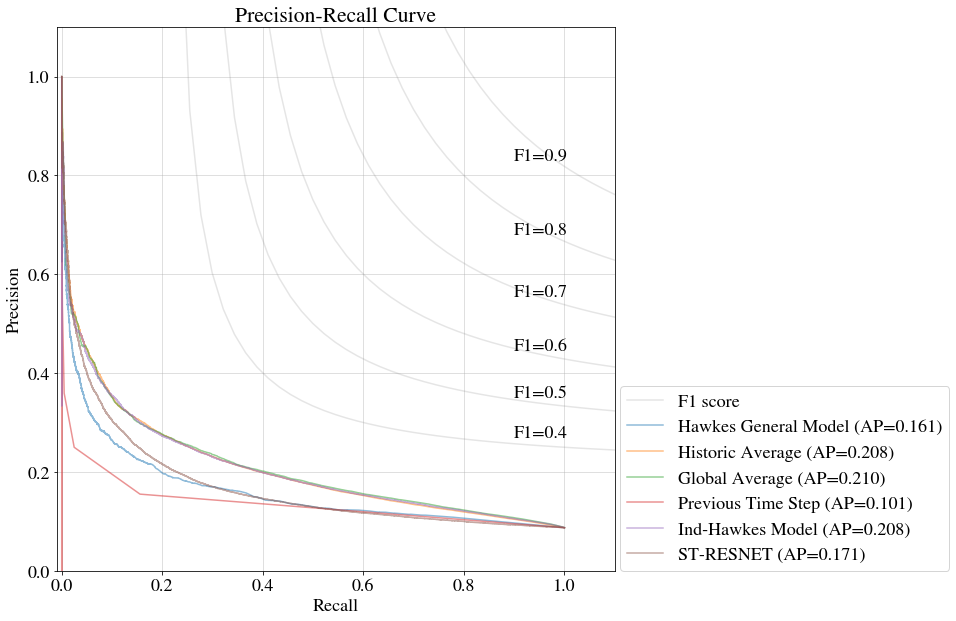

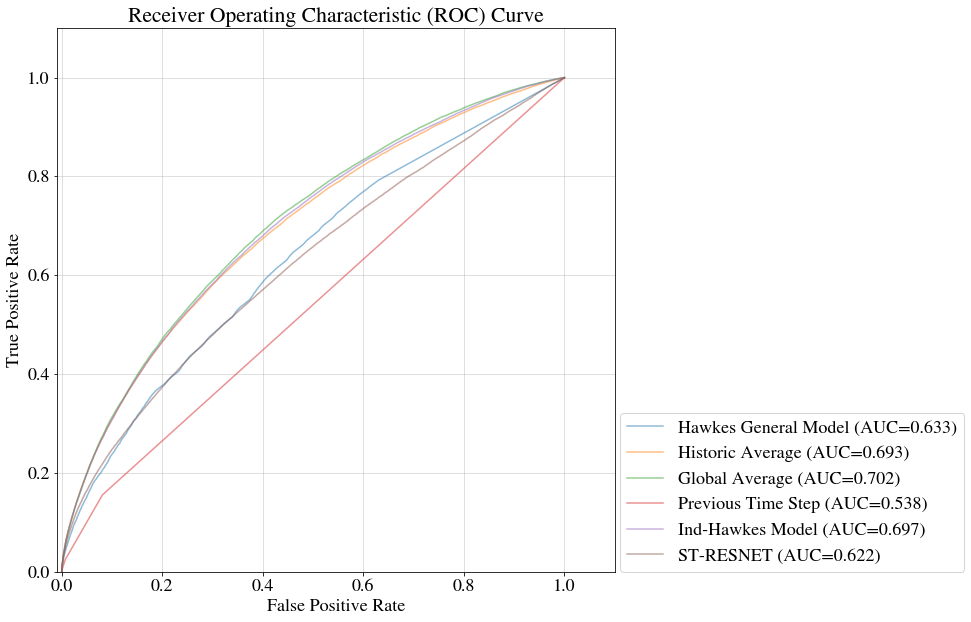

ROC AUC  Avg. Precision  ...  Accuracy  Matthews Corrcoef
Model Name                                      ...                             
Global Average        0.701786        0.209651  ...  0.801578           0.185448
Historic Average      0.692959        0.208087  ...  0.812324           0.182211
Ind-Hawkes Model      0.696819        0.207758  ...  0.805479           0.182268
Hawkes General Model  0.632604        0.161331  ...  0.780211           0.126935
ST-RESNET             0.622035        0.171405  ...  0.846520           0.132291
Previous Time Step    0.537794        0.100964  ...  0.087233           0.000000

[6 rows x 7 columns]

In [16]:
trn_y_counts, trn_y_true, trn_probas_pred, trn_t_range = evaluate_fn(model=model,
                                                                     batch_loader=loaders.train_loader,
                                                                     conf=conf) 
thresh = best_threshold(trn_y_true, trn_probas_pred) 

tst_y_counts, tst_y_true, tst_probas_pred, tst_t_range = evaluate_fn(model=model,
                                                                     batch_loader=loaders.test_loader,
                                                                     conf=conf)


tst_y_true = np.expand_dims(tst_y_true, axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1) 

tst_y_true = data_group.shaper.squeeze(tst_y_true)
tst_probas_pred = data_group.shaper.squeeze(tst_probas_pred)


tst_y_pred = get_y_pred(thresh, tst_probas_pred)
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)
compare_models(data_path=conf.data_path)

In [0]:
models_results = get_models_results(data_path=conf.data_path)

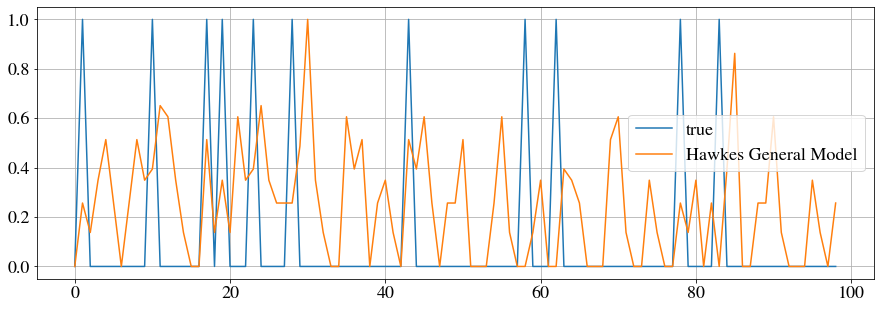

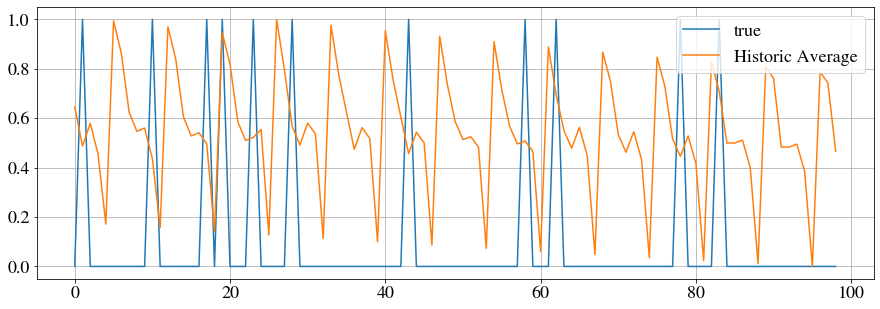

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


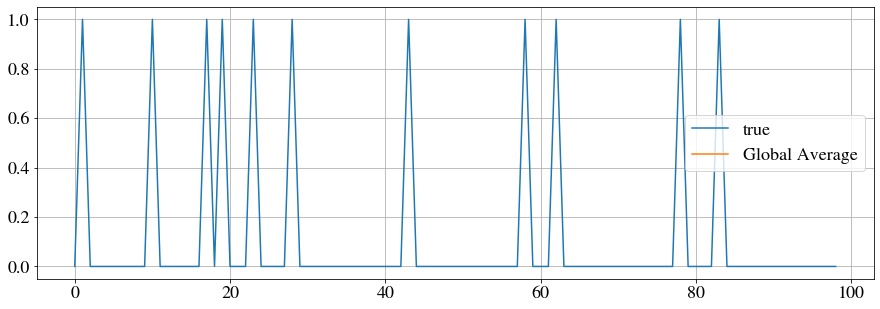

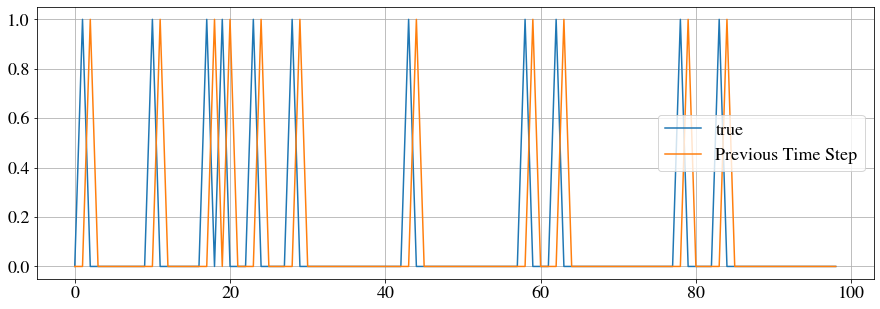

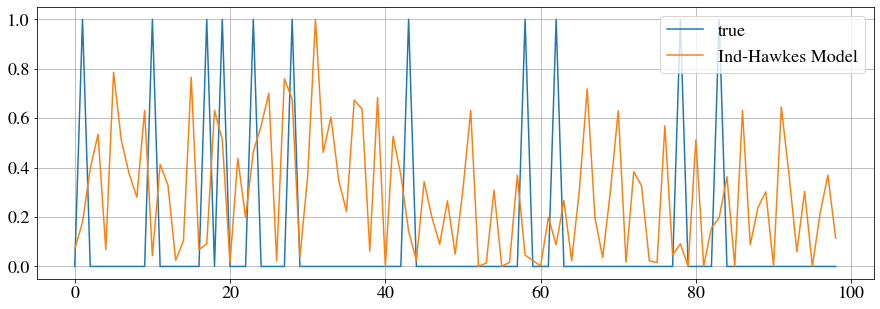

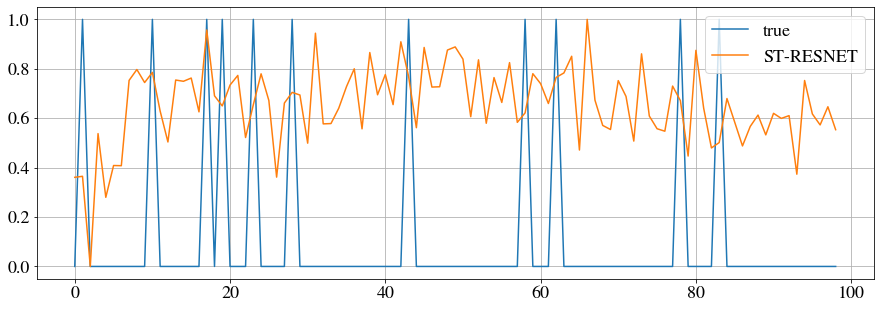

In [18]:
m = models_results[0]

def norm(x):
#     return x
    x = x - np.min(x)
    x = x / np.max(x)
    return x

i = 0
lim = 100
for m in models_results:
    
    plt.figure(figsize=(15,5))
    y_true = m.y_true[:lim,0,i]#.sum(1)
    plt.plot(norm(y_true),label='true')

    x0 = m.probas_pred[:lim,0,i]#.sum(1)
    plt.plot(norm(x0),label=f"{m.model_name} (normerd)")
    plt.plot(x0,label=m.model_name)

    plt.grid()
    plt.legend()
    plt.show()


In [19]:
m = models_results[1]
m.y_true.shape

(99, 1, 4935)

In [20]:
targets = [m.shaper for m in models_results]
for t in targets:
    print(t.l)

4935
4935
4935
4935
4935
4935


----------------------------------------------------------------------------------------------------

## All in one

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, best_threshold, get_y_pred
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics
from trainers.generic_trainer import train_model
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths
from models.model_result import save_metrics, compare_models, get_models_metrics, get_models_results
from models.st_resnet_models import STResNet, STResNetExtra
from models.st_resnet_models import train_epoch_for_st_res_net, train_epoch_for_st_res_net_extra
from models.st_resnet_models import evaluate_st_res_net, evaluate_st_res_net_extra

In [9]:
data_sub_paths = get_data_sub_paths()
# data_sub_paths = ['T24H-X850M-Y880M_2013-01-01_2015-01-01']
data_sub_paths = [
    'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
    'T1H-X850M-Y880M_2013-01-01_2015-01-01',
    'T3H-X850M-Y880M_2013-01-01_2015-01-01',
    'T6H-X850M-Y880M_2013-01-01_2015-01-01',
    'T12H-X850M-Y880M_2013-01-01_2015-01-01',
    'T24H-X850M-Y880M_2013-01-01_2015-01-01',
    'T24H-X425M-Y440M_2013-01-01_2015-01-01',
    'T24H-X255M-Y220M_2013-01-01_2015-01-01',
    'T24H-X85M-Y110M_2013-01-01_2015-01-01',
]
data_sub_paths

['T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01',
 'T3H-X850M-Y880M_2013-01-01_2015-01-01',
 'T6H-X850M-Y880M_2013-01-01_2015-01-01',
 'T12H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T24H-X85M-Y110M_2013-01-01_2015-01-01']

2019-11-12T10:05:06 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:05:06 | root | INFO | Device: cuda:0
2019-11-12T10:05:06 | root | INFO | 	t_range shape (17521,)
2019-11-12T10:05:12 | root | INFO | lr: 		0.0005
2019-11-12T10:05:12 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:05:12 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T10:05:12 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': 'H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/ST-RESNET/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 'n_steps_p': 3,
 

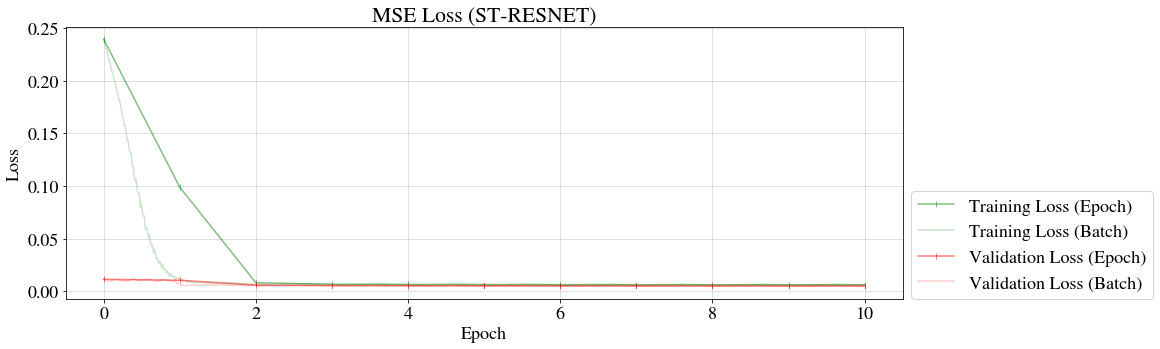

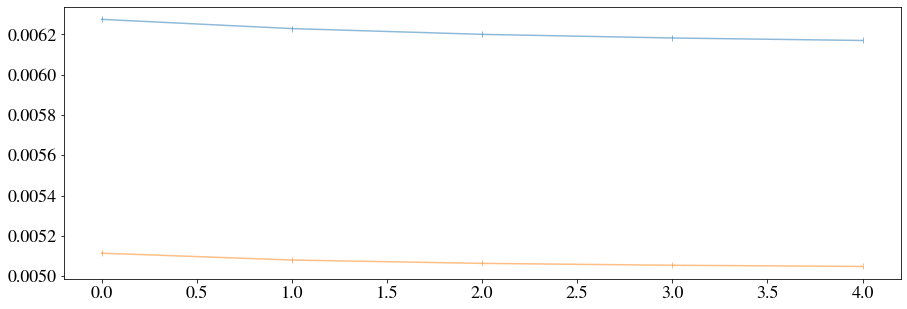

2019-11-12T10:06:21 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:06:21 | root | INFO | loading model from ./data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T10:06:26 | root | INFO | f1_score: 0.3515776221045509 at index 1418220, new threshold 0.06485531479120255


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-11-12T10:06:37 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7538892952026239                
                Average Precision:  0.2662589789079282
                Precision:          0.2506539039456842
                Recall:             0.46856144147143275
                Accuracy:           0.7994263585647733
                MCC:                0.23624528537860326          
        
2019-11-12T10:06:37 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7538892952026239
                Average Precision:  0.2662589789079282                
                Precision:          0.2506539039456842
                Recall:             0.46856144147143275
                Accuracy:           0.7994263585647733
                MCC:                0.23624528537860326          
        
2019-11-12T10:06:44 | root | INFO | 
                       ROC AUC  Avg. Precisi

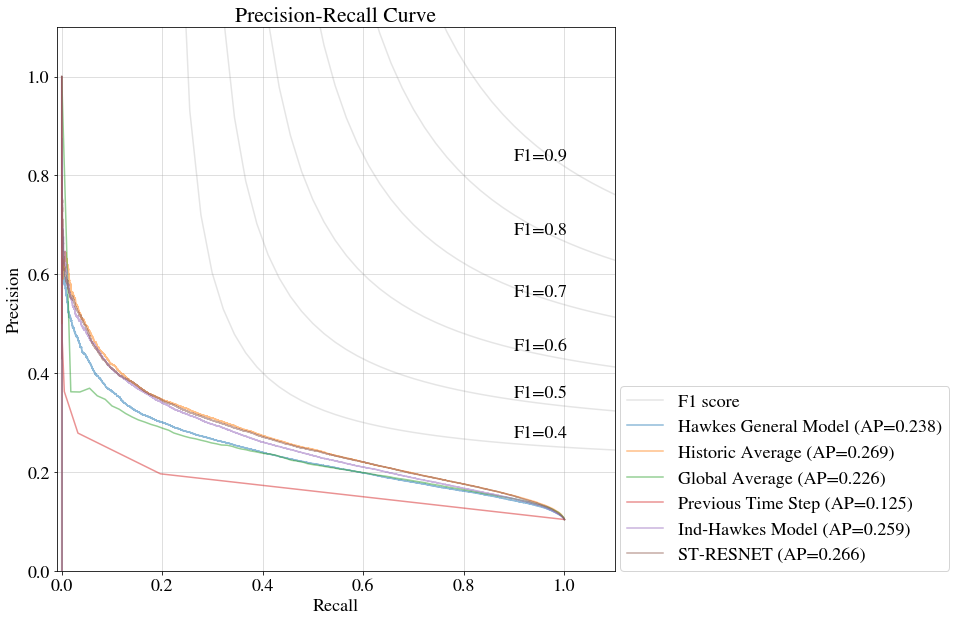

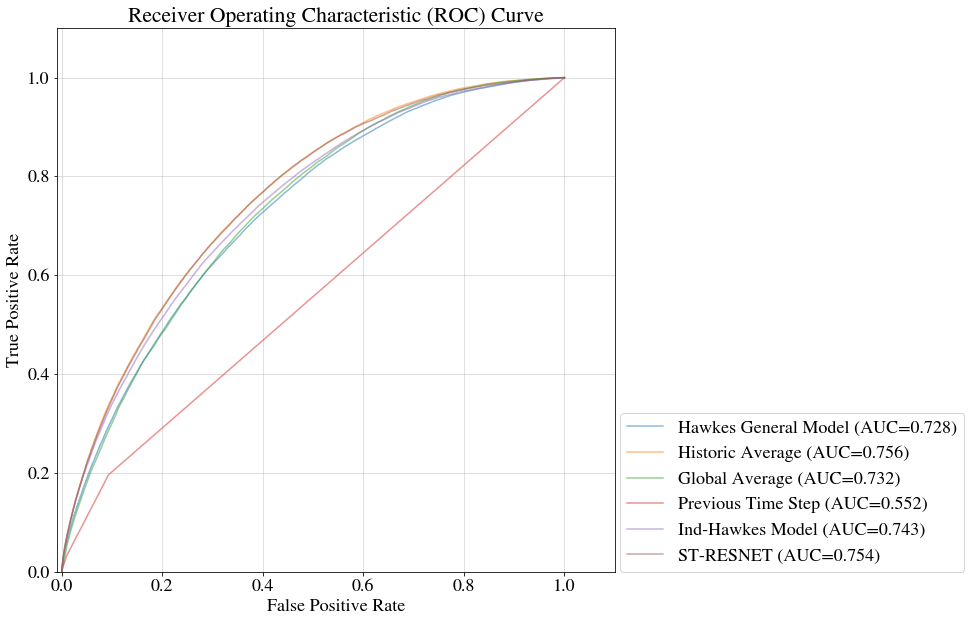

2019-11-12T10:06:46 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:06:46 | root | INFO | Device: cuda:0
2019-11-12T10:06:46 | root | INFO | 	t_range shape (17521,)
2019-11-12T10:06:46 | root | INFO | lr: 		0.0005
2019-11-12T10:06:46 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:06:46 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T10:06:46 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': 'H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,


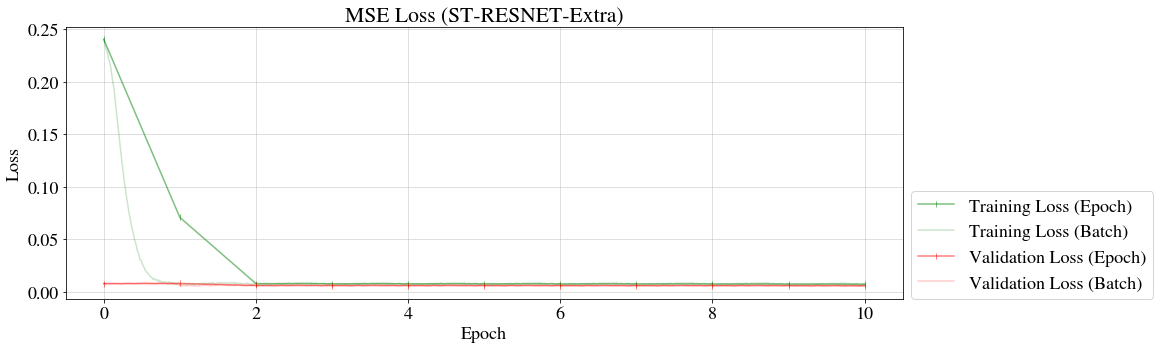

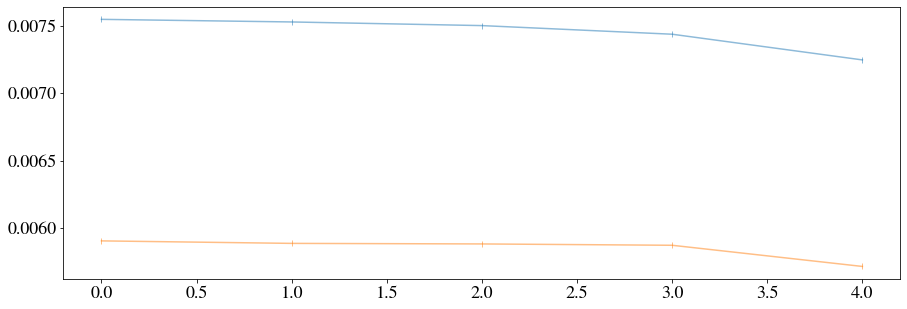

2019-11-12T10:08:09 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:08:09 | root | INFO | loading model from ./data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T10:08:14 | root | INFO | f1_score: 0.22279756684901378 at index 1677778, new threshold 0.03606816381216049
2019-11-12T10:08:25 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.5605839057583915                
                Average Precision:  0.16018921137253192
                Precision:          0.19859017539984908
                Recall:             0.2245016853231243
                Accuracy:           0.8254562026060082
                MCC:                0.11331293699526686          
        
2019-11-12T10:08:25 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.5605839057583915
                Average Precision:  0.

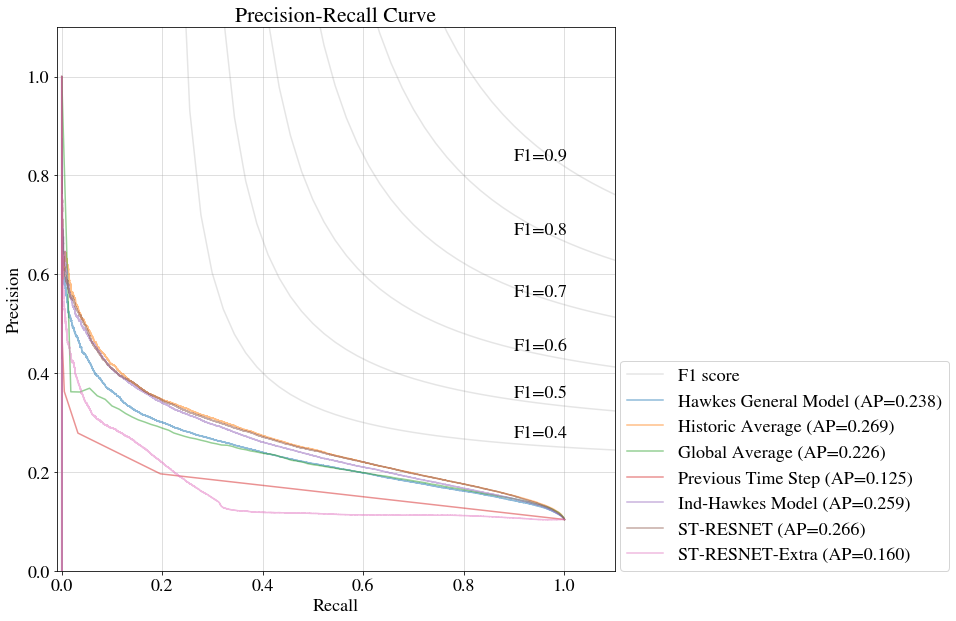

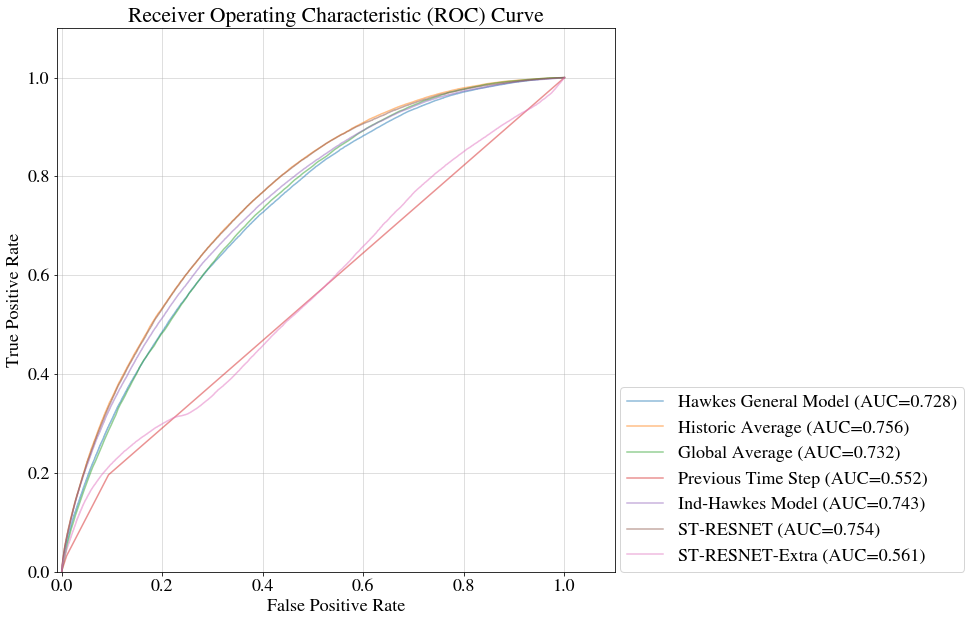

2019-11-12T10:08:31 | root | INFO | 
========================= T1H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-12T10:08:31 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:08:31 | root | INFO | Device: cuda:0
2019-11-12T10:08:32 | root | INFO | 	t_range shape (17521,)
2019-11-12T10:08:34 | root | INFO | lr: 		0.0005
2019-11-12T10:08:34 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:08:34 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T10:08:34 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': 'H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T1H

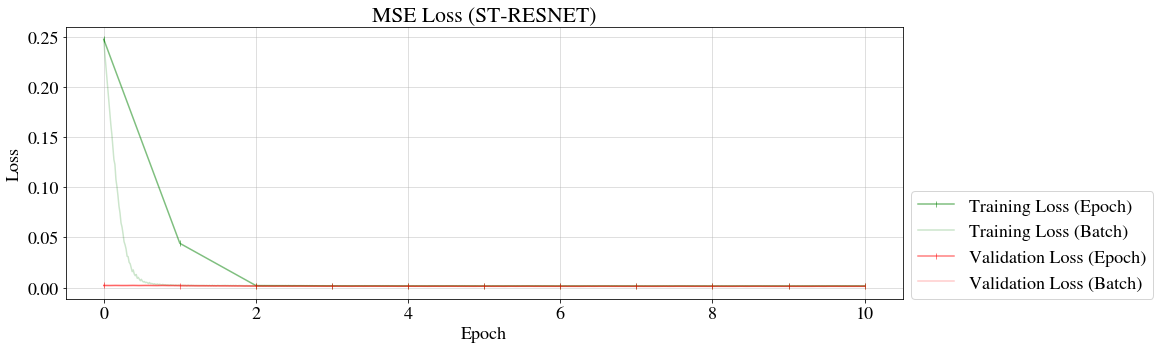

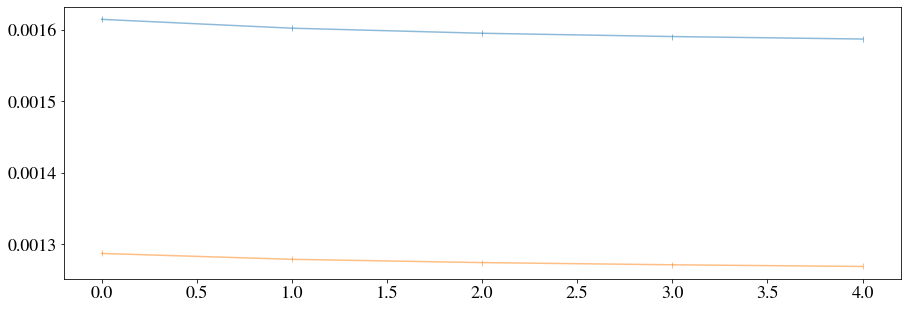

2019-11-12T10:10:04 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:10:04 | root | INFO | loading model from ./data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T10:10:14 | root | INFO | f1_score: 0.16422820723014533 at index 3616655, new threshold 0.028438011184334755
2019-11-12T10:10:30 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.734570133129498                
                Average Precision:  0.09417517825554292
                Precision:          0.10769057284618855
                Recall:             0.25179381909263826
                Accuracy:           0.9106281225914407
                MCC:                0.12295655496777977          
        
2019-11-12T10:10:30 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.734570133129498
                Average Precision:  0.09417517825554292   

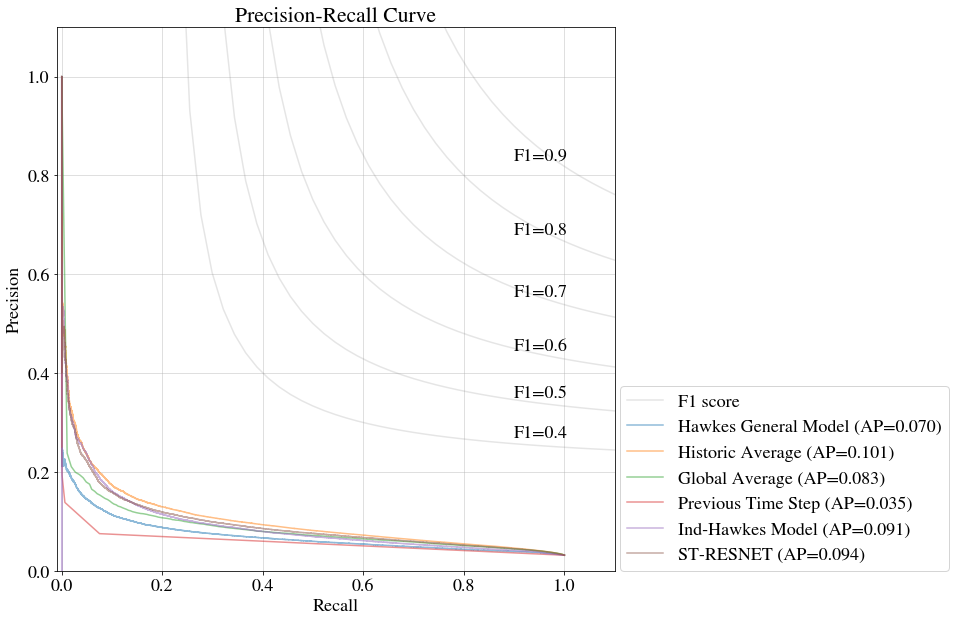

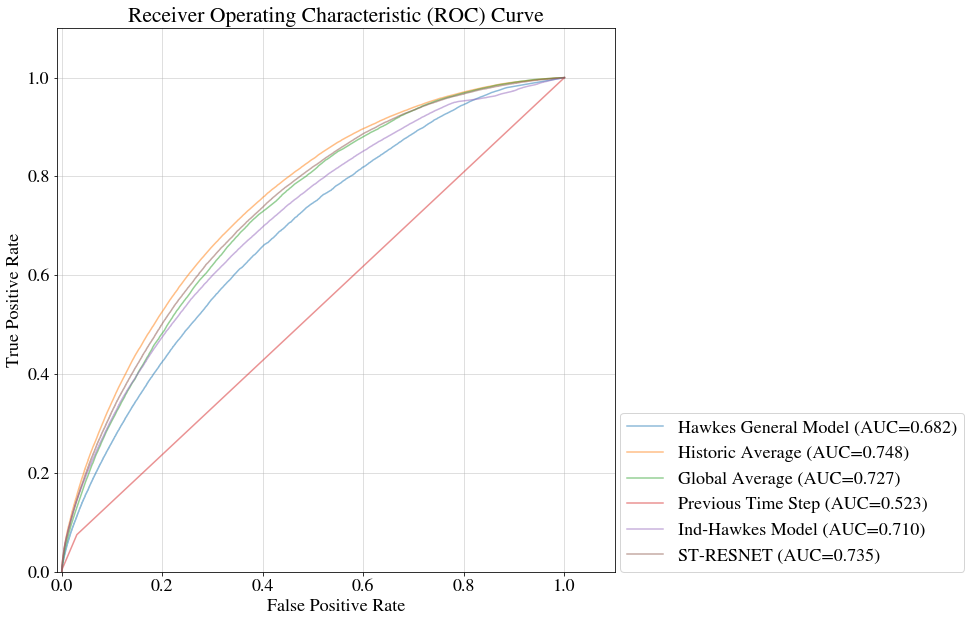

2019-11-12T10:10:52 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:10:52 | root | INFO | Device: cuda:0
2019-11-12T10:10:53 | root | INFO | 	t_range shape (17521,)
2019-11-12T10:10:55 | root | INFO | lr: 		0.0005
2019-11-12T10:10:55 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:10:55 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T10:10:55 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': 'H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 'n_

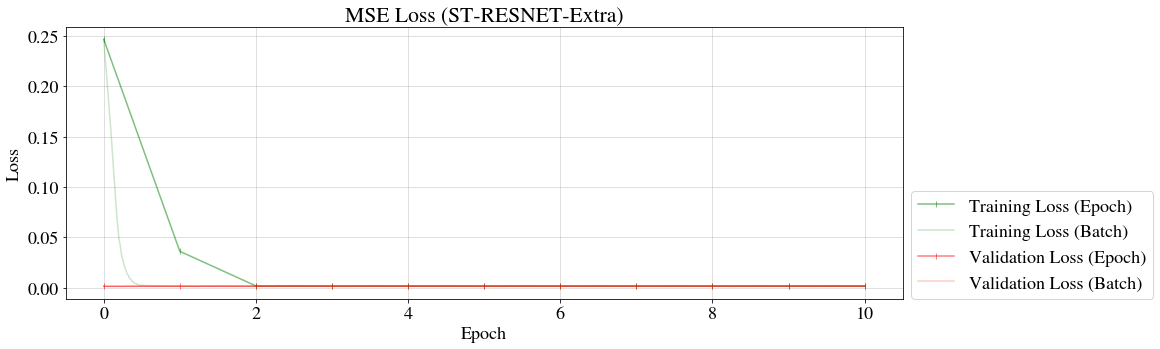

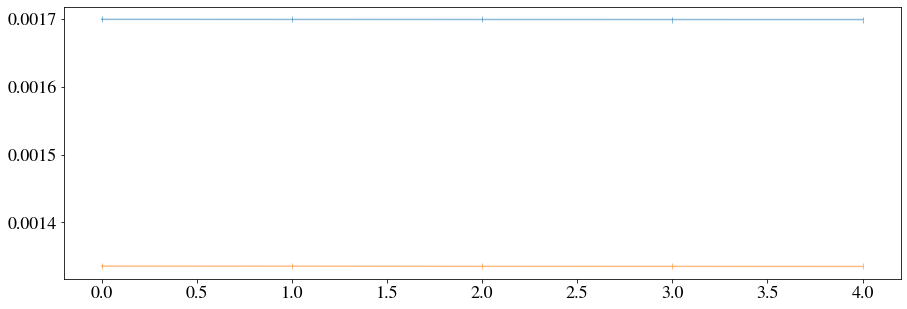

2019-11-12T10:12:44 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:12:44 | root | INFO | loading model from ./data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T10:12:57 | root | INFO | f1_score: 0.03111008968805546 at index 0, new threshold 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-12T10:13:13 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.37109255276587927                
                Average Precision:  0.023212059685825858
                Precision:          0.03152963782392711
                Recall:             1.0
                Accuracy:           0.03152963782392711
                MCC:                0.0          
        
2019-11-12T10:13:13 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.37109255276587927
                Average Precision:  0.023212059685825858                
                Precision:          0.03152963782392711
                Recall:             1.0
                Accuracy:           0.03152963782392711
                MCC:                0.0          
        


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-12T10:13:29 | root | INFO | 
                       ROC AUC  Avg. Precision  ...  Accuracy  Matthews Corrcoef
Model Name                                      ...                             
Historic Average      0.747532        0.101228  ...  0.914354           0.132059
ST-RESNET             0.734570        0.094175  ...  0.910628           0.122957
Ind-Hawkes Model      0.710276        0.090826  ...  0.920120           0.115217
Global Average        0.727132        0.082812  ...  0.894656           0.115359
Hawkes General Model  0.681533        0.069940  ...  0.907360           0.089510
Previous Time Step    0.522583        0.035261  ...  0.941682           0.045072
ST-RESNET-Extra       0.371093        0.023212  ...  0.031530           0.000000

[7 rows x 7 columns]


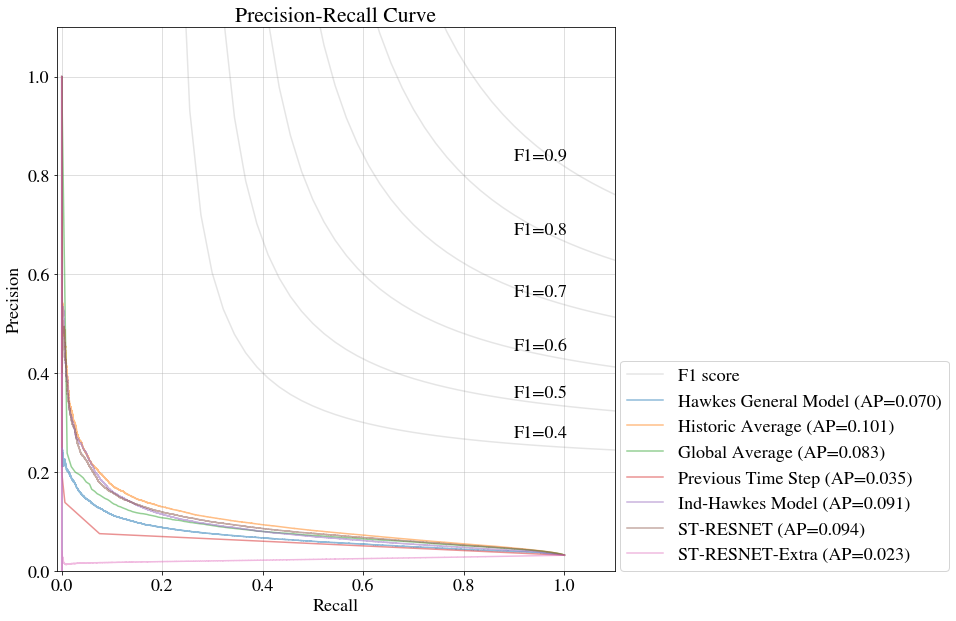

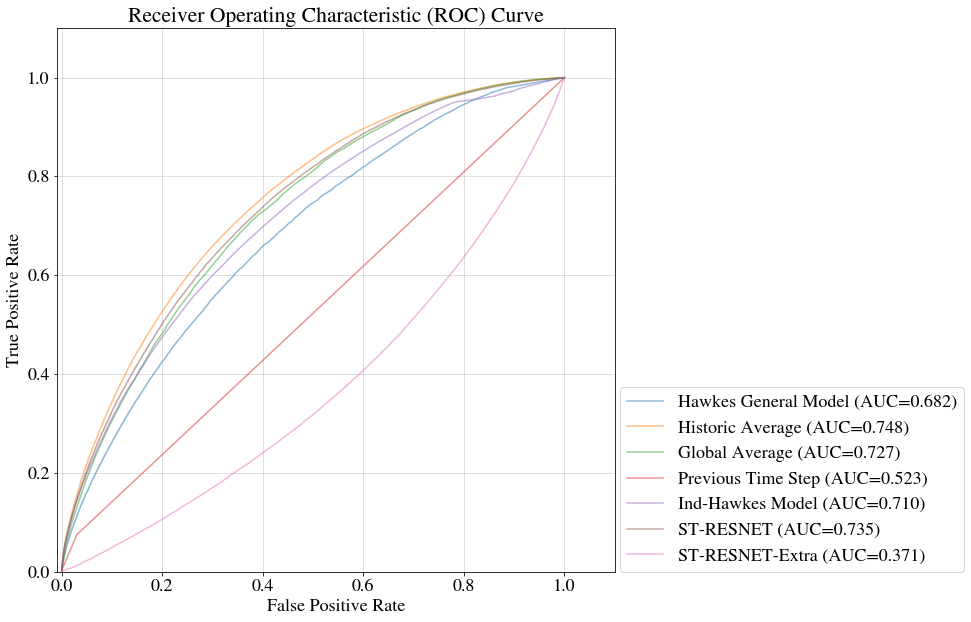

2019-11-12T10:13:32 | root | INFO | 
========================= T3H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-12T10:13:32 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:13:32 | root | INFO | Device: cuda:0
2019-11-12T10:13:33 | root | INFO | 	t_range shape (5841,)
2019-11-12T10:13:33 | root | INFO | lr: 		0.0005
2019-11-12T10:13:33 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:13:33 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T10:13:33 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '3H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T3H

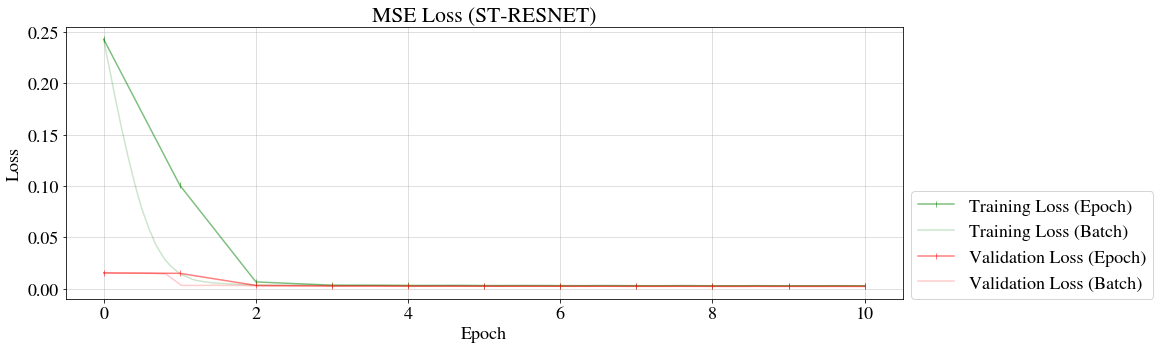

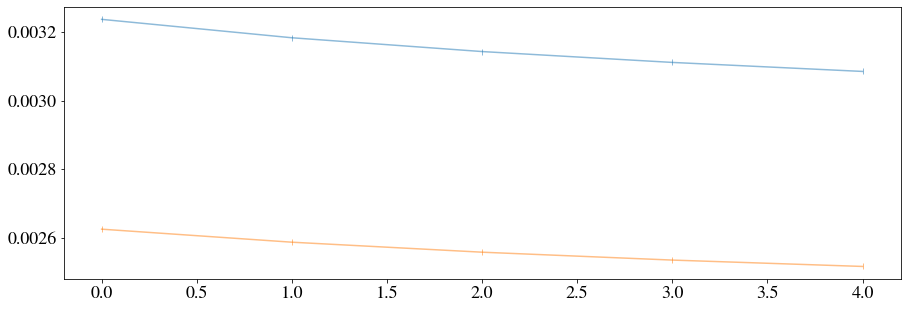

2019-11-12T10:14:08 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:14:08 | root | INFO | loading model from ./data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T10:14:11 | root | INFO | f1_score: 0.3073398345576235 at index 1453283, new threshold 0.04190773516893387
2019-11-12T10:14:17 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7366141962065227                
                Average Precision:  0.2309499071396443
                Precision:          0.20684596577017114
                Recall:             0.4452721715014474
                Accuracy:           0.8007712632243296
                MCC:                0.20271225971313833          
        
2019-11-12T10:14:17 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7366141962065227
                Average Precision:  0.2309499071396443      

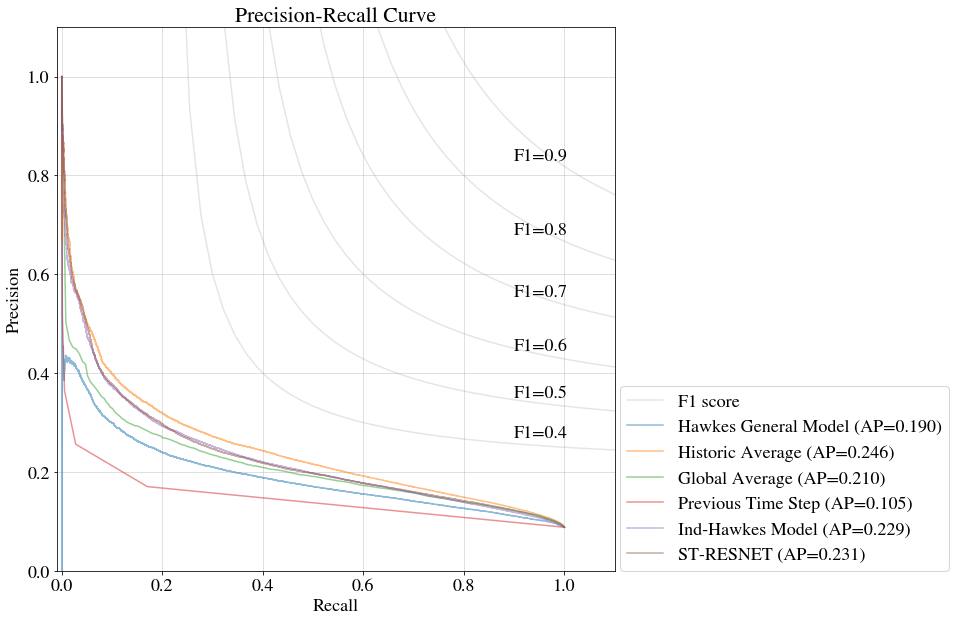

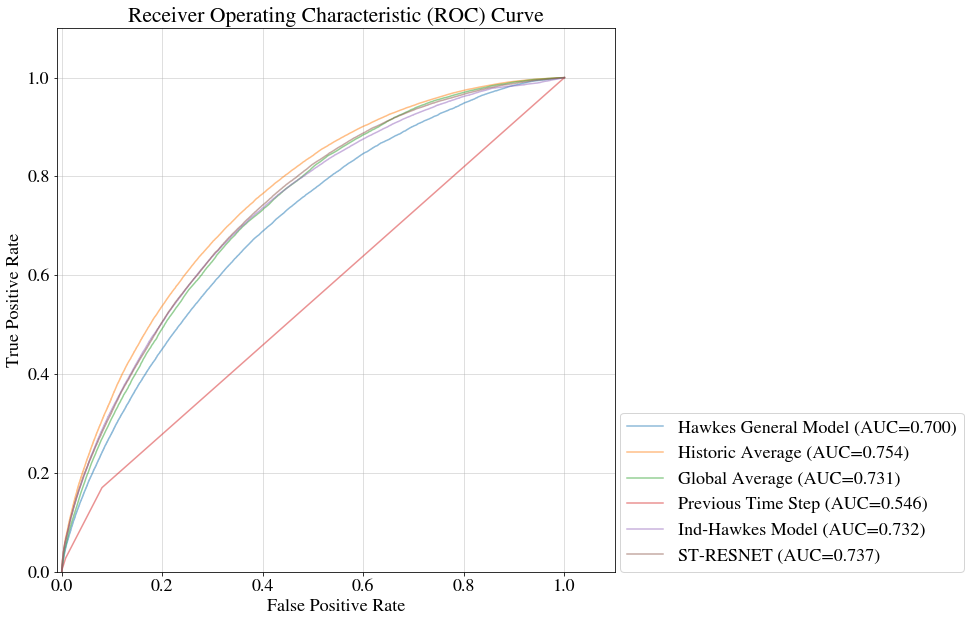

2019-11-12T10:14:25 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:14:25 | root | INFO | Device: cuda:0
2019-11-12T10:14:26 | root | INFO | 	t_range shape (5841,)
2019-11-12T10:14:26 | root | INFO | lr: 		0.0005
2019-11-12T10:14:26 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:14:26 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T10:14:26 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '3H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 'n_

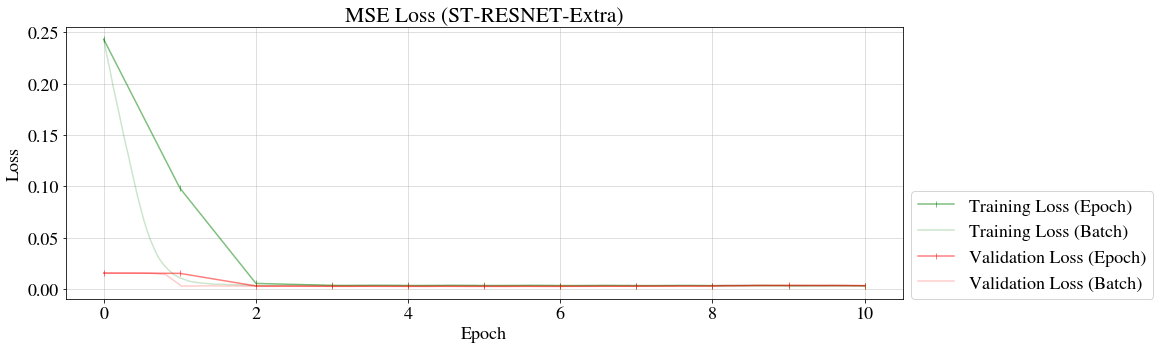

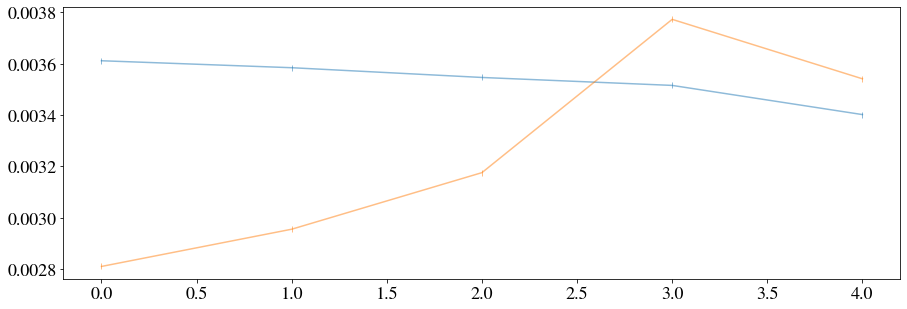

2019-11-12T10:15:06 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:15:06 | root | INFO | loading model from ./data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T10:15:10 | root | INFO | f1_score: 0.08400247066090179 at index 0, new threshold 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-12T10:15:16 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.4811592525058699                
                Average Precision:  0.1033267610553257
                Precision:          0.08807127142546417
                Recall:             1.0
                Accuracy:           0.08807127142546417
                MCC:                0.0          
        
2019-11-12T10:15:16 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.4811592525058699
                Average Precision:  0.1033267610553257                
                Precision:          0.08807127142546417
                Recall:             1.0
                Accuracy:           0.08807127142546417
                MCC:                0.0          
        


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-12T10:15:21 | root | INFO | 
                       ROC AUC  Avg. Precision  ...  Accuracy  Matthews Corrcoef
Model Name                                      ...                             
Historic Average      0.753655        0.246152  ...  0.816567           0.226921
Ind-Hawkes Model      0.732156        0.229147  ...  0.810666           0.205045
ST-RESNET             0.736614        0.230950  ...  0.800771           0.202712
Global Average        0.731416        0.210335  ...  0.775505           0.197994
Hawkes General Model  0.699960        0.190031  ...  0.801565           0.169251
Previous Time Step    0.545570        0.105401  ...  0.853899           0.090245
ST-RESNET-Extra       0.481159        0.103327  ...  0.088071           0.000000

[7 rows x 7 columns]


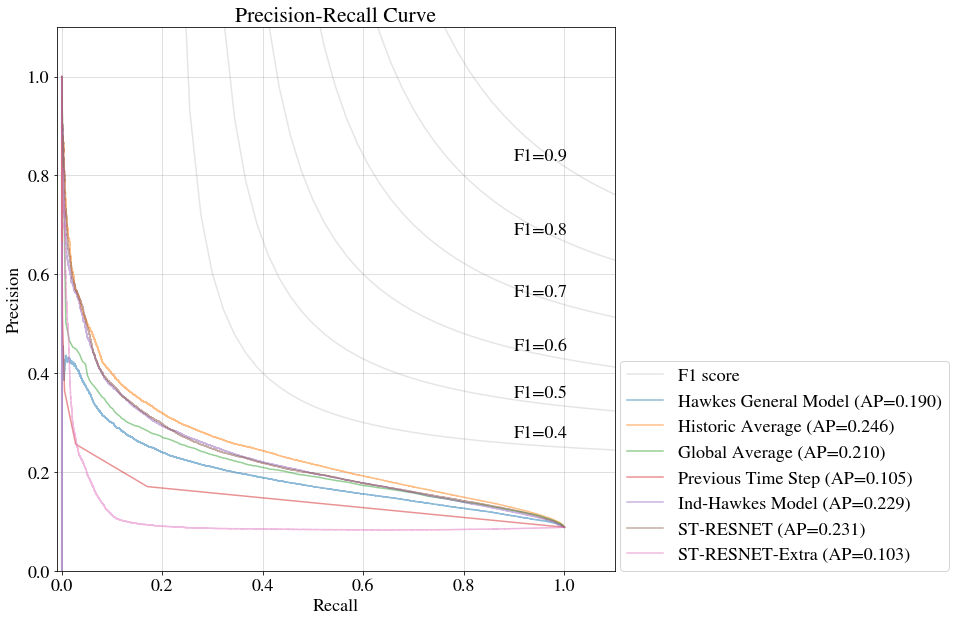

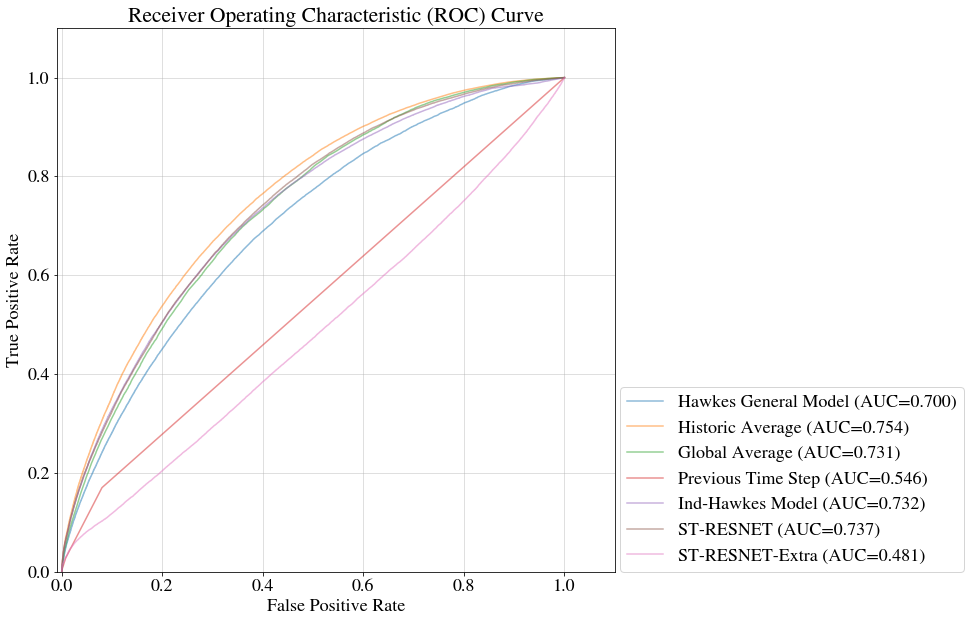

2019-11-12T10:15:23 | root | INFO | 
========================= T6H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-12T10:15:23 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:15:23 | root | INFO | Device: cuda:0
2019-11-12T10:15:24 | root | INFO | 	t_range shape (2921,)
2019-11-12T10:15:25 | root | INFO | lr: 		0.0005
2019-11-12T10:15:25 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:15:25 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T10:15:25 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '6H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T6H

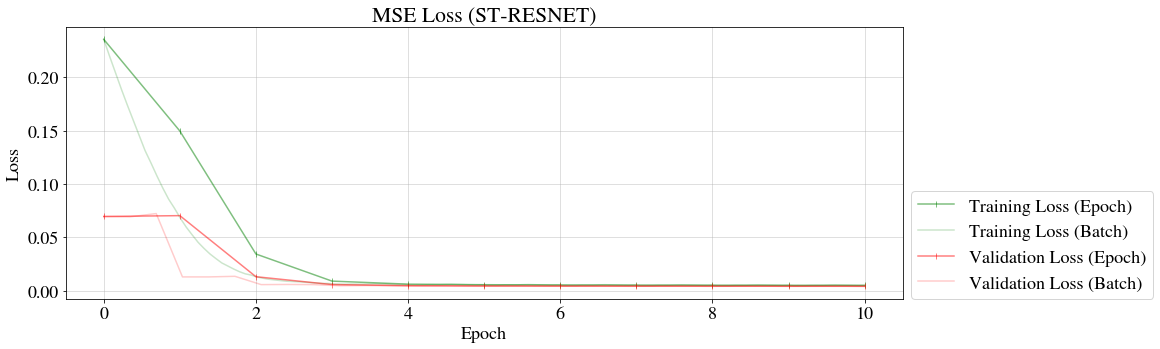

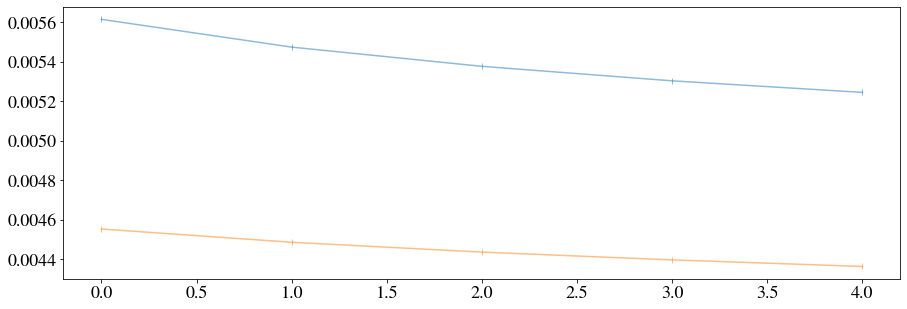

2019-11-12T10:15:45 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:15:45 | root | INFO | loading model from ./data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T10:15:47 | root | INFO | f1_score: 0.43563728370054533 at index 844624, new threshold 0.05269400775432587
2019-11-12T10:15:50 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7427826267560654                
                Average Precision:  0.37462652065084723
                Precision:          0.3055552443792219
                Recall:             0.6043605424089338
                Accuracy:           0.7149319166863026
                MCC:                0.2686775453100257          
        
2019-11-12T10:15:50 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7427826267560654
                Average Precision:  0.37462652065084723      

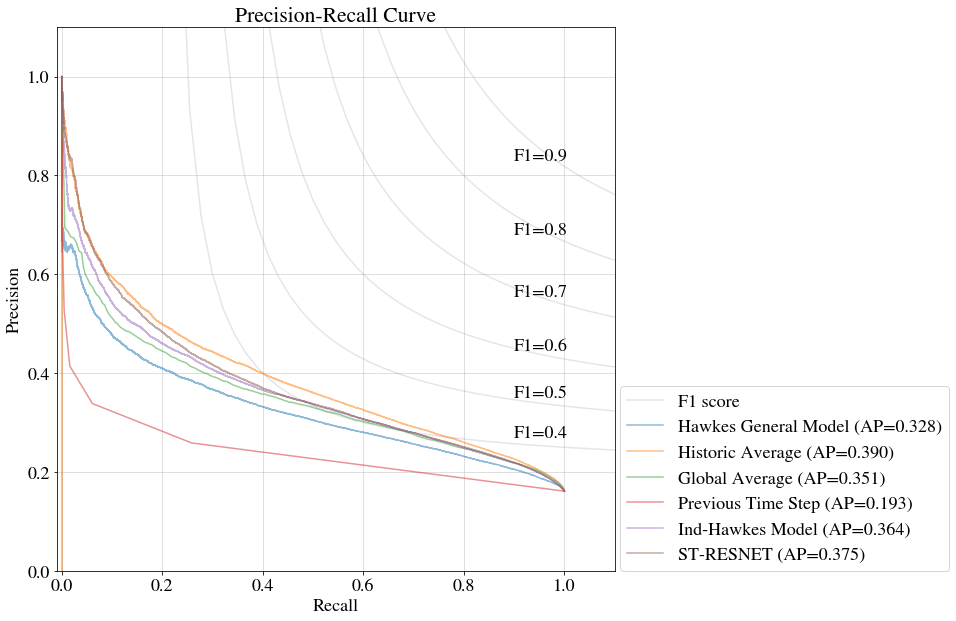

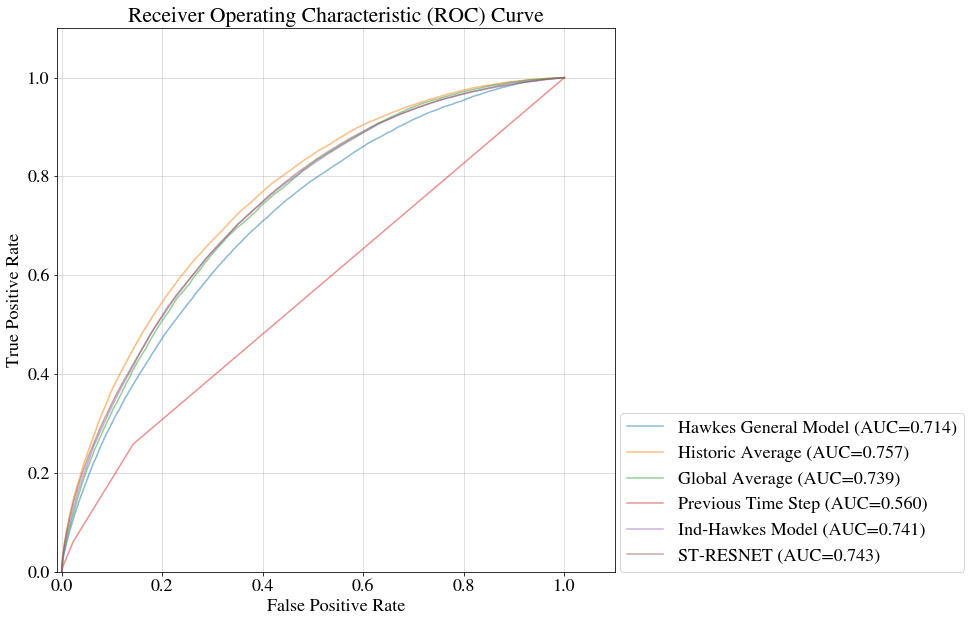

2019-11-12T10:15:55 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:15:55 | root | INFO | Device: cuda:0
2019-11-12T10:15:55 | root | INFO | 	t_range shape (2921,)
2019-11-12T10:15:56 | root | INFO | lr: 		0.0005
2019-11-12T10:15:56 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:15:56 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T10:15:56 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '6H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 'n_

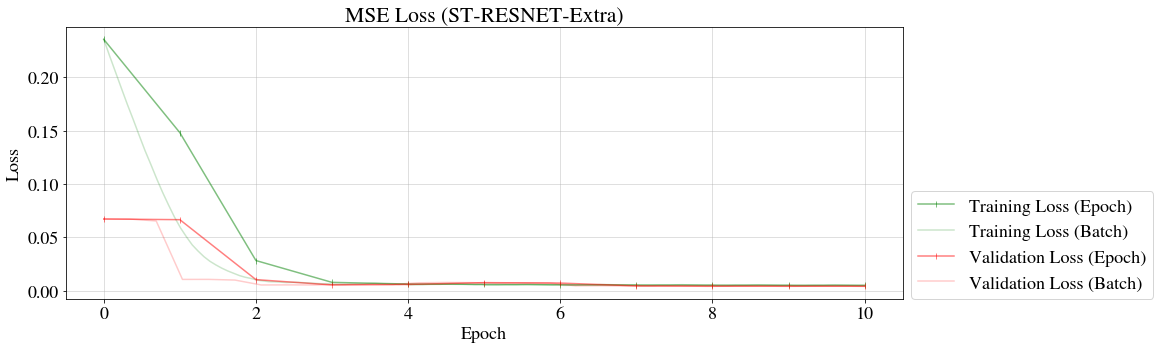

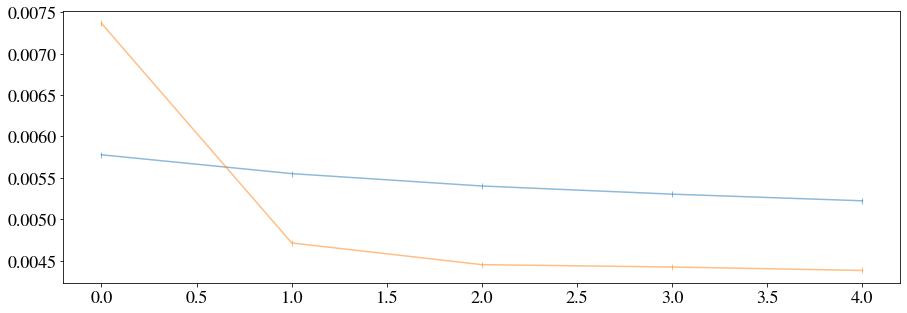

2019-11-12T10:16:19 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:16:19 | root | INFO | loading model from ./data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T10:16:22 | root | INFO | f1_score: 0.4269224667319323 at index 1037719, new threshold 0.06992636620998383
2019-11-12T10:16:24 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7229846403037832                
                Average Precision:  0.3623314415241038
                Precision:          0.3062204429177905
                Recall:             0.5609766905964726
                Accuracy:           0.7244714349977508
                MCC:                0.25539311479140747          
        
2019-11-12T10:16:25 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7229846403037832
                Average Precision:  0.36233

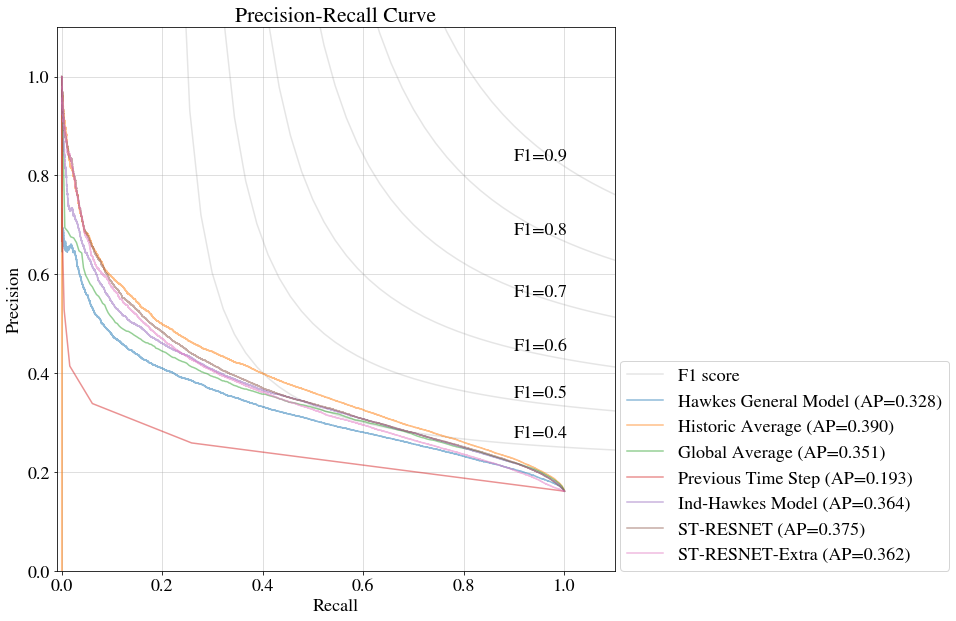

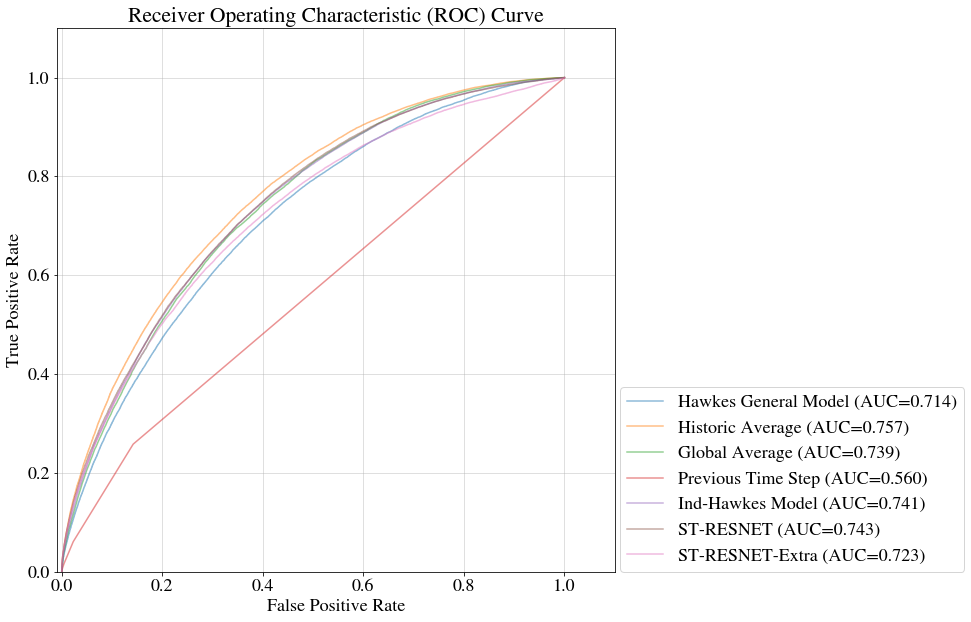

2019-11-12T10:16:29 | root | INFO | 
========================= T12H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-12T10:16:29 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:16:29 | root | INFO | Device: cuda:0
2019-11-12T10:16:30 | root | INFO | 	t_range shape (1461,)
2019-11-12T10:16:30 | root | INFO | lr: 		0.0005
2019-11-12T10:16:30 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:16:30 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T10:16:30 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '12H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/

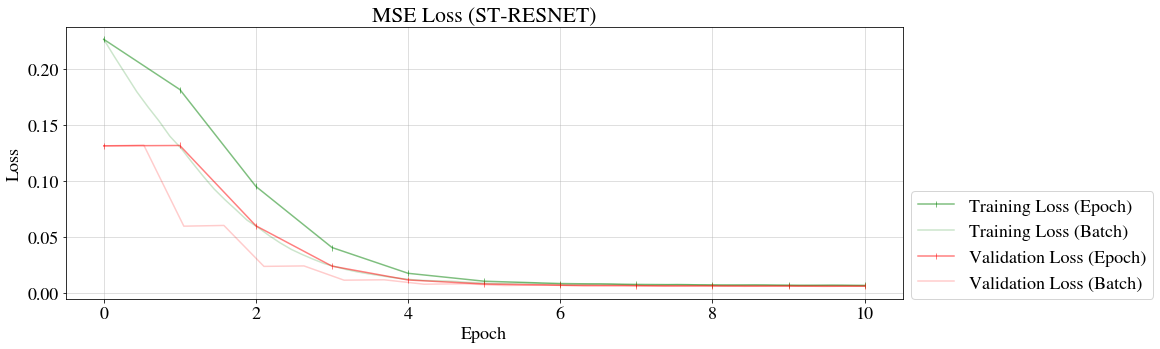

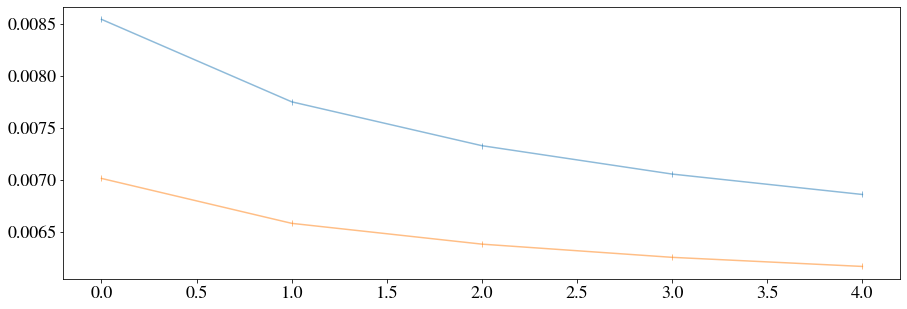

2019-11-12T10:16:44 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:16:44 | root | INFO | loading model from ./data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T10:16:45 | root | INFO | f1_score: 0.5801796805148483 at index 442511, new threshold 0.05098092555999756
2019-11-12T10:16:46 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7560987309150915                
                Average Precision:  0.5558632580932213
                Precision:          0.44704671213486036
                Recall:             0.7135301668806162
                Accuracy:           0.6740540308379505
                MCC:                0.3359485526247814          
        
2019-11-12T10:16:46 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7560987309150915
                Average Precision:  0.5558632580932213       

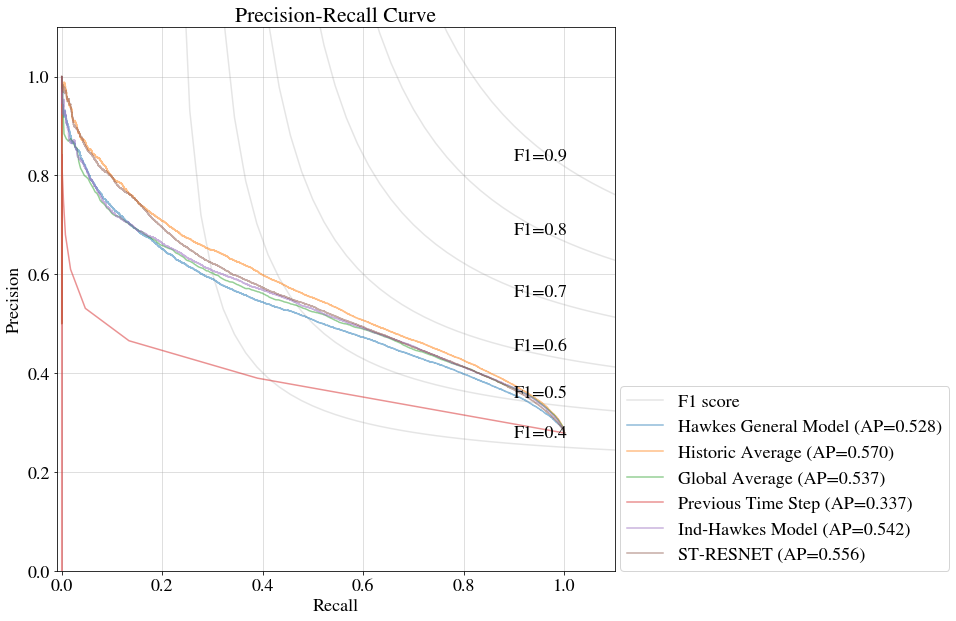

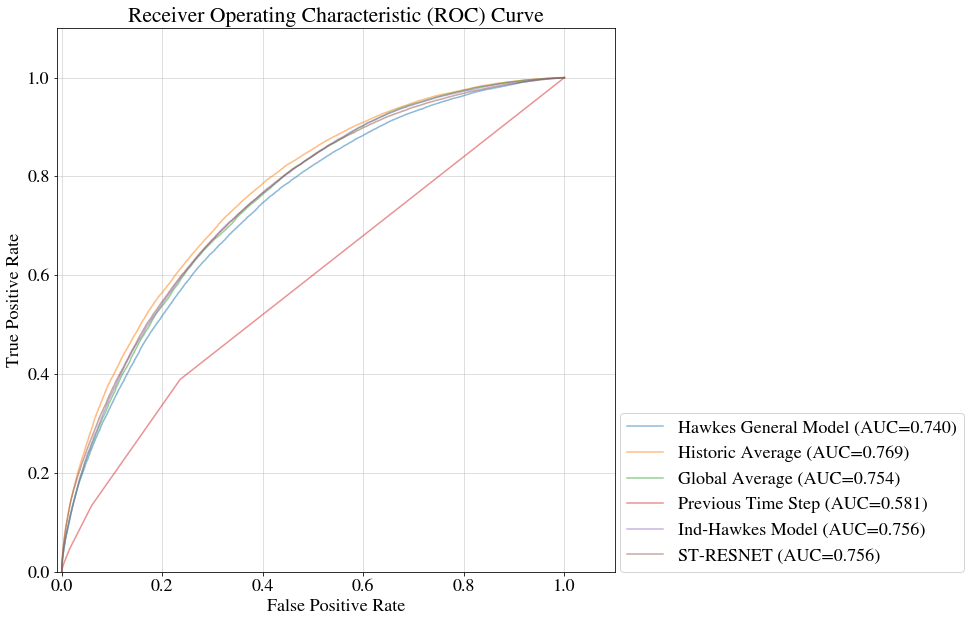

2019-11-12T10:16:51 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:16:51 | root | INFO | Device: cuda:0
2019-11-12T10:16:51 | root | INFO | 	t_range shape (1461,)
2019-11-12T10:16:51 | root | INFO | lr: 		0.0005
2019-11-12T10:16:51 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:16:51 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T10:16:51 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '12H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 

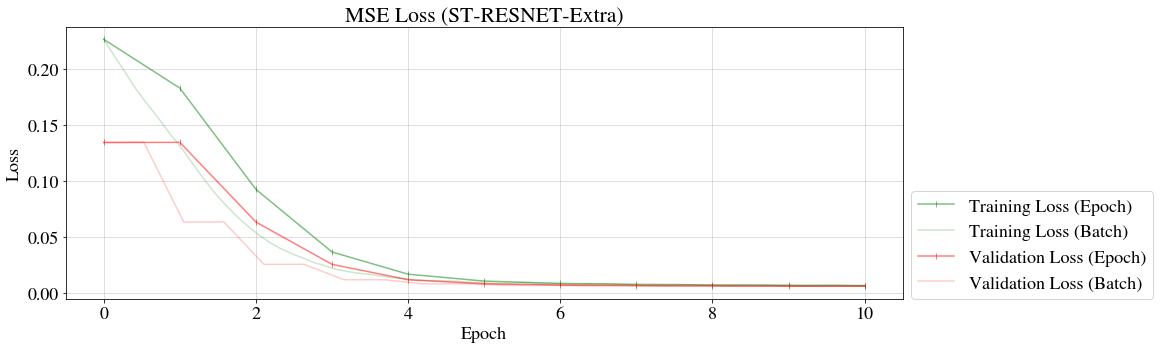

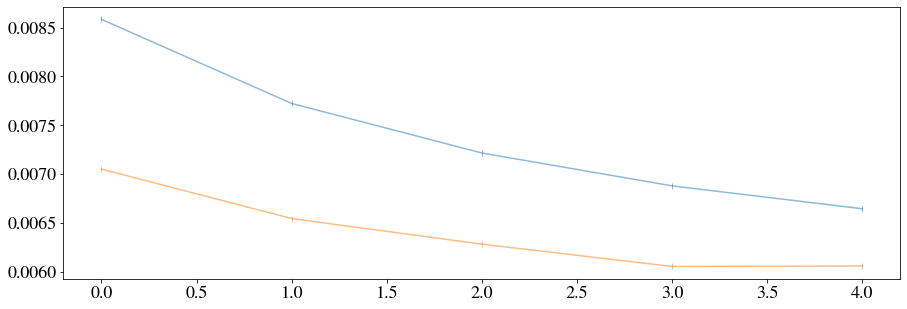

2019-11-12T10:17:07 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:17:07 | root | INFO | loading model from ./data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T10:17:09 | root | INFO | f1_score: 0.5645330838742032 at index 483684, new threshold 0.07379937916994095
2019-11-12T10:17:10 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7301928964159384                
                Average Precision:  0.5419207983333079
                Precision:          0.43847586071731887
                Recall:             0.6892682926829268
                Accuracy:           0.6672536471531446
                MCC:                0.31451251308817213          
        
2019-11-12T10:17:10 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7301928964159384
                Average Precision:  0.5419

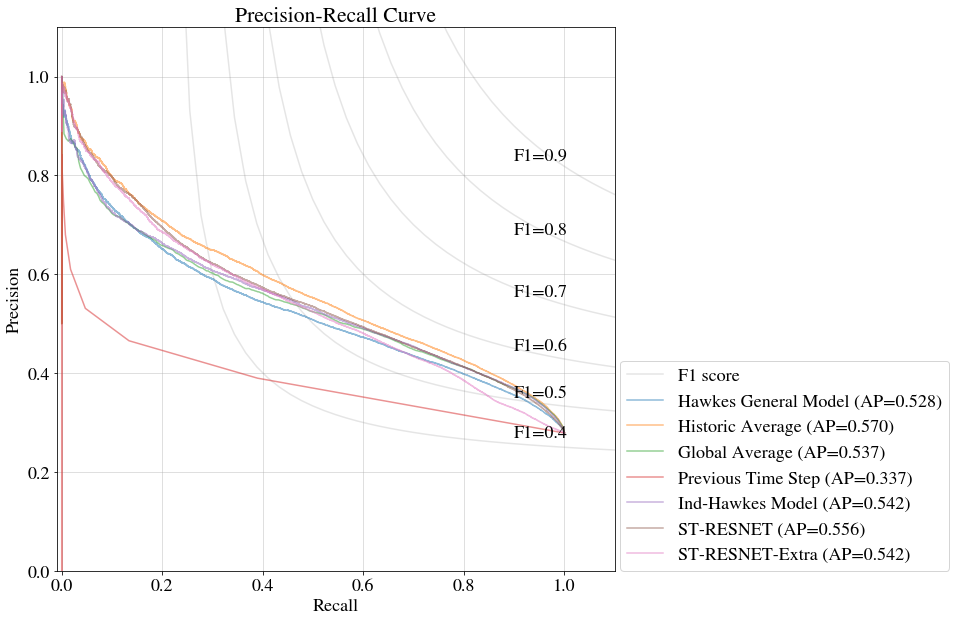

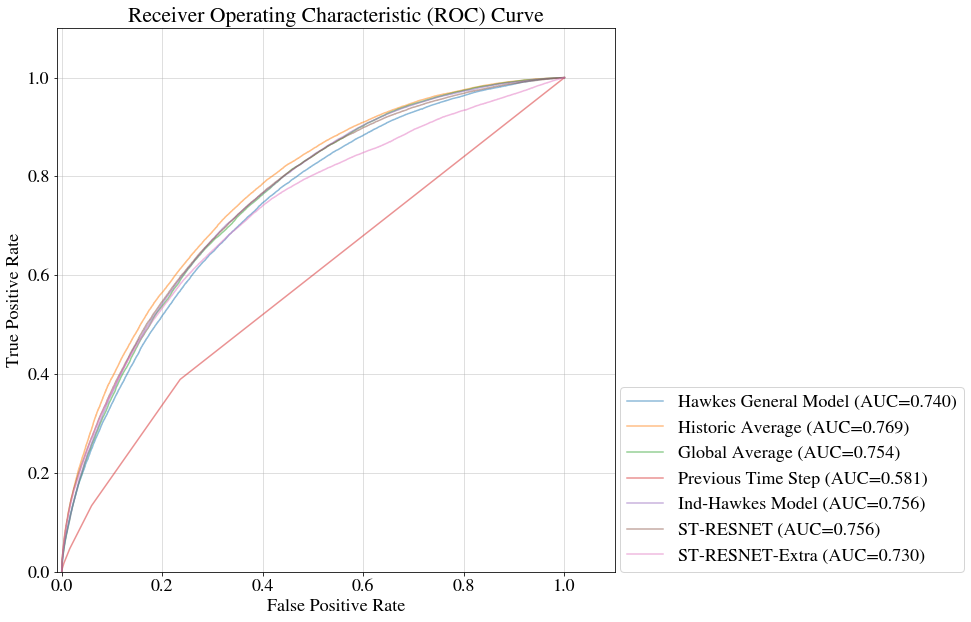

2019-11-12T10:17:13 | root | INFO | 
========================= T24H-X850M-Y880M_2013-01-01_2015-01-01 =========================

2019-11-12T10:17:13 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:17:13 | root | INFO | Device: cuda:0
2019-11-12T10:17:13 | root | INFO | 	t_range shape (731,)
2019-11-12T10:17:13 | root | INFO | lr: 		0.0005
2019-11-12T10:17:13 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:17:13 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T10:17:13 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T

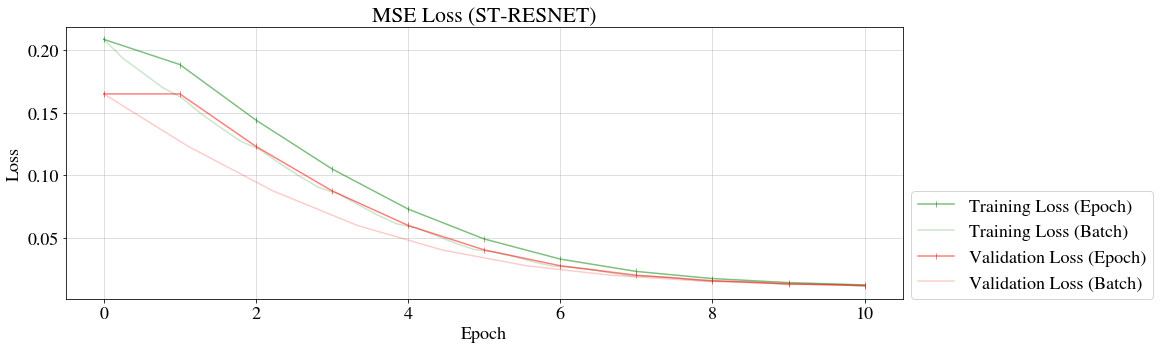

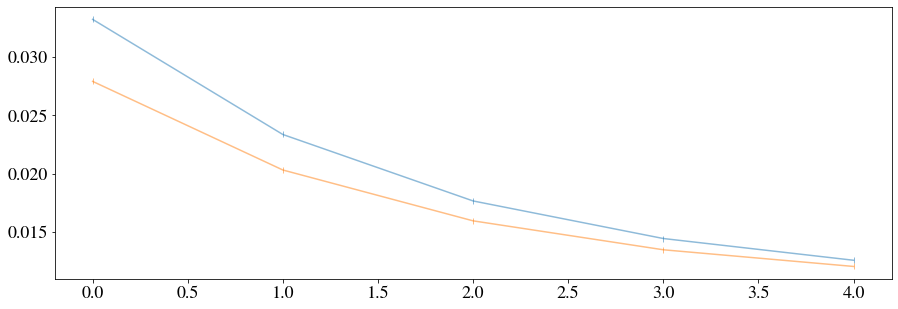

2019-11-12T10:17:24 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:17:24 | root | INFO | loading model from ./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T10:17:25 | root | INFO | f1_score: 0.7170742987730228 at index 215613, new threshold 0.09296511858701706
2019-11-12T10:17:26 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7725914896552247                
                Average Precision:  0.7391524943582435
                Precision:          0.5325418421739293
                Recall:             0.9160655317238947
                Accuracy:           0.6014417681084347
                MCC:                0.30981862651901276          
        
2019-11-12T10:17:26 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7725914896552247
                Average Precision:  0.7391524943582435       

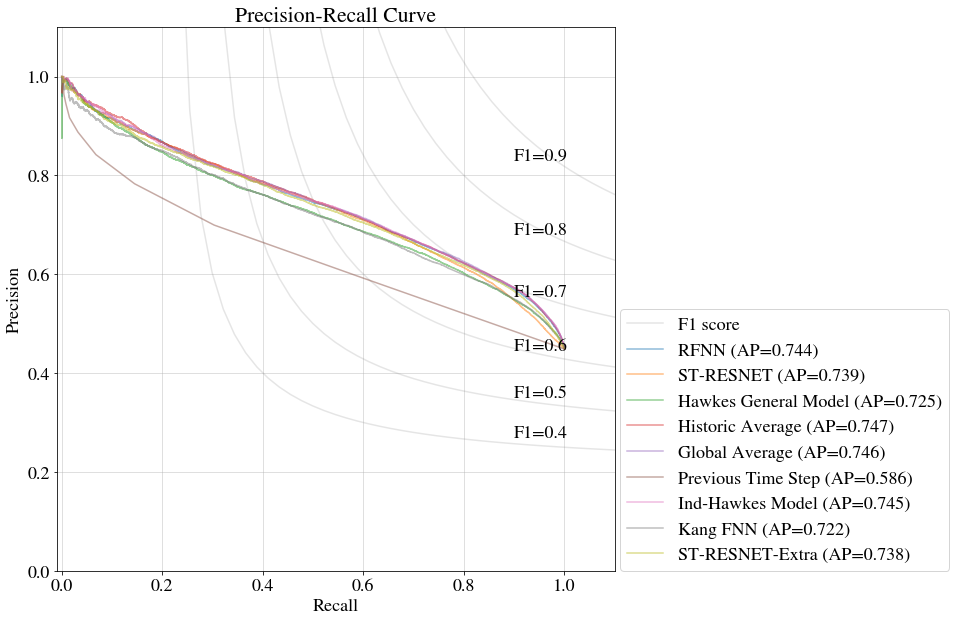

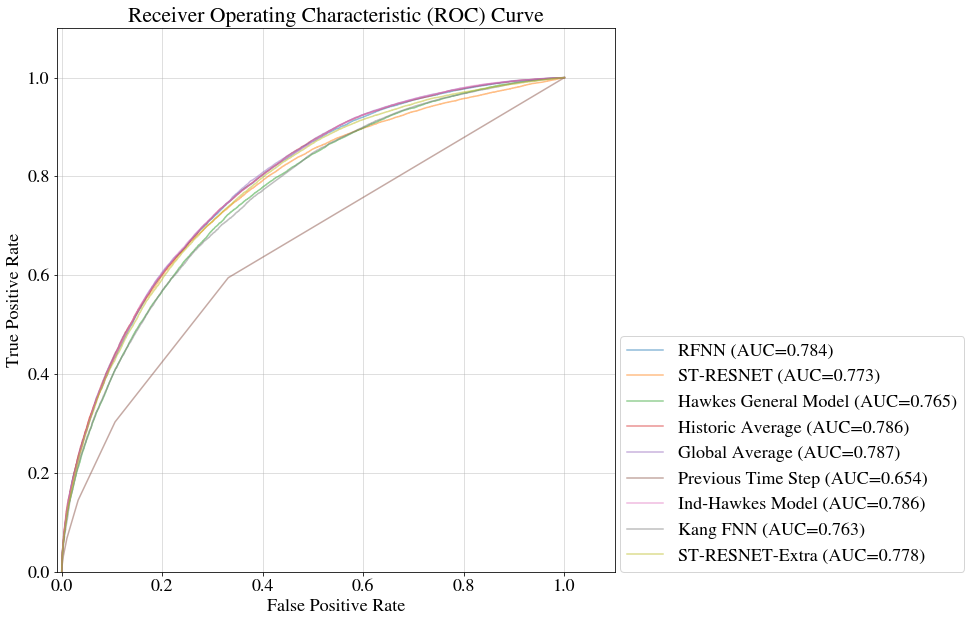

2019-11-12T10:17:28 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:17:28 | root | INFO | Device: cuda:0
2019-11-12T10:17:28 | root | INFO | 	t_range shape (731,)
2019-11-12T10:17:28 | root | INFO | lr: 		0.0005
2019-11-12T10:17:28 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:17:28 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T10:17:28 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 '

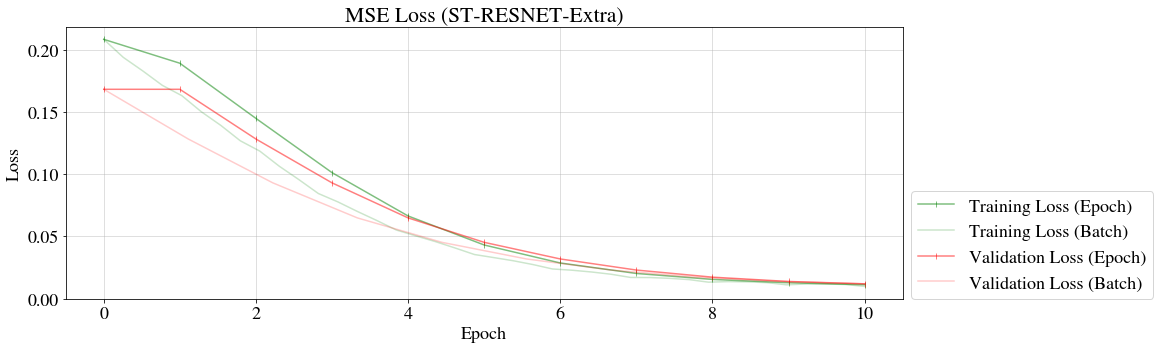

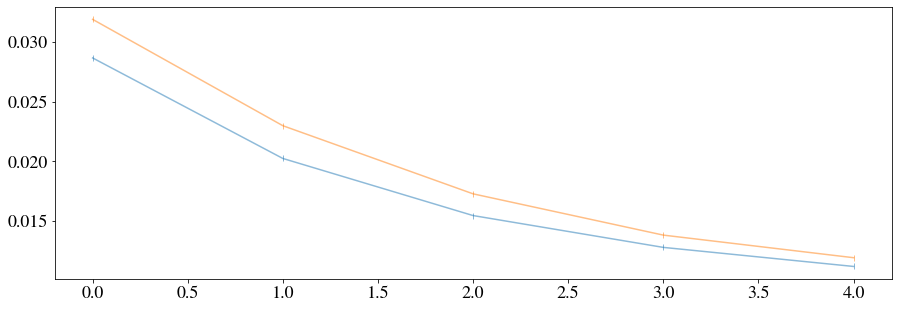

2019-11-12T10:17:41 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:17:41 | root | INFO | loading model from ./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T10:17:41 | root | INFO | f1_score: 0.7100724618305303 at index 223349, new threshold 0.11777563393115997
2019-11-12T10:17:42 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7670791607451204                
                Average Precision:  0.7337414005048012
                Precision:          0.594808152641242
                Recall:             0.8205572120162867
                Accuracy:           0.6685947797058908
                MCC:                0.37427844377509023          
        
2019-11-12T10:17:42 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7670791607451204
                Average Precision:  0.733741

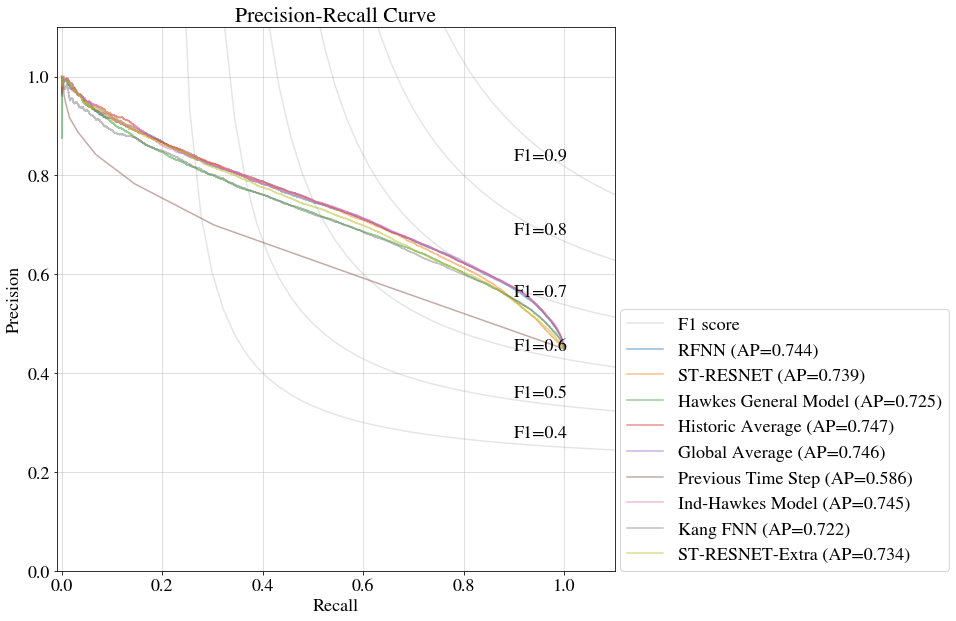

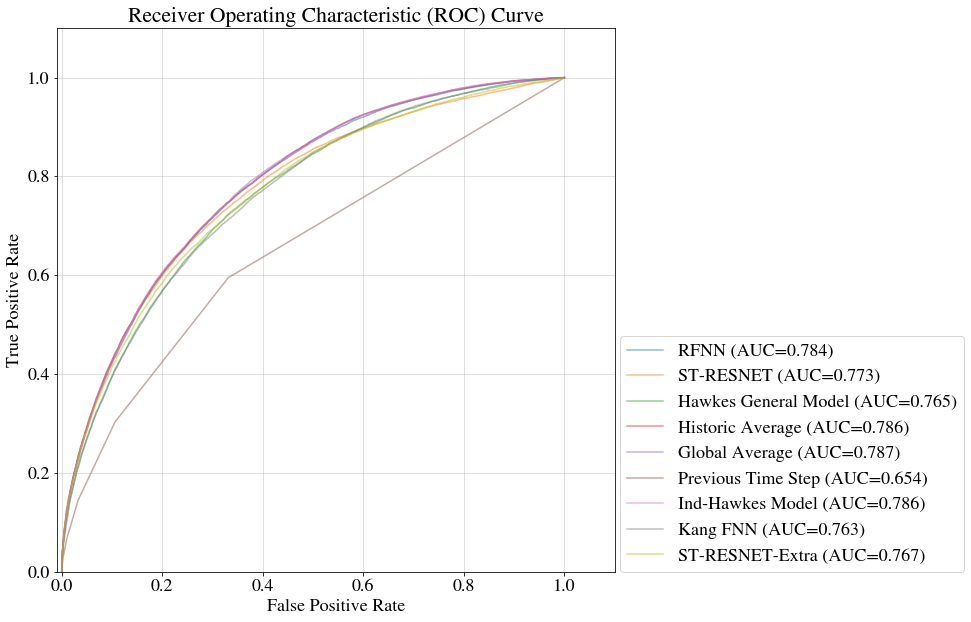

2019-11-12T10:17:44 | root | INFO | 
========================= T24H-X425M-Y440M_2013-01-01_2015-01-01 =========================

2019-11-12T10:17:44 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:17:44 | root | INFO | Device: cuda:0
2019-11-12T10:17:45 | root | INFO | 	t_range shape (731,)
2019-11-12T10:17:46 | root | INFO | lr: 		0.0005
2019-11-12T10:17:46 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:17:46 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T10:17:46 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T

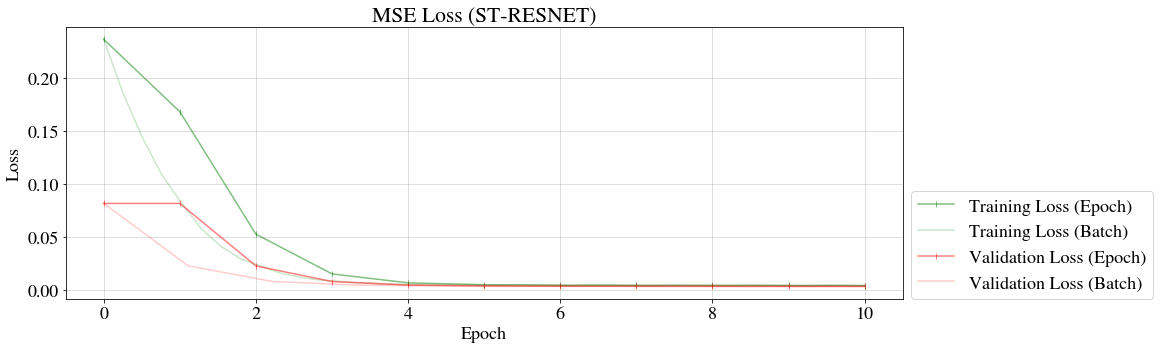

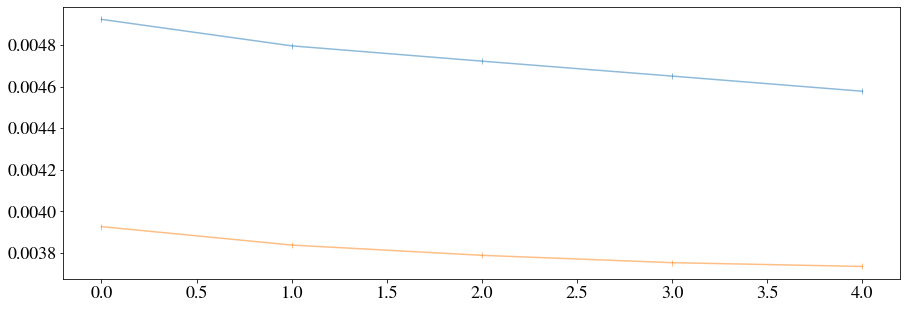

2019-11-12T10:18:37 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:18:37 | root | INFO | loading model from ./data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/models/ST-RESNET/
2019-11-12T10:18:39 | root | INFO | f1_score: 0.45637116898074087 at index 695008, new threshold 0.018691718578338623
2019-11-12T10:18:41 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET
                ROC AUC:            0.7144160530470196                
                Average Precision:  0.3946446897984004
                Precision:          0.28707996970424693
                Recall:             0.7233690972141411
                Accuracy:           0.6088230127360562
                MCC:                0.23939320589910582          
        
2019-11-12T10:18:41 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET
                ROC AUC:            0.7144160530470196
                Average Precision:  0.3946446897984004    

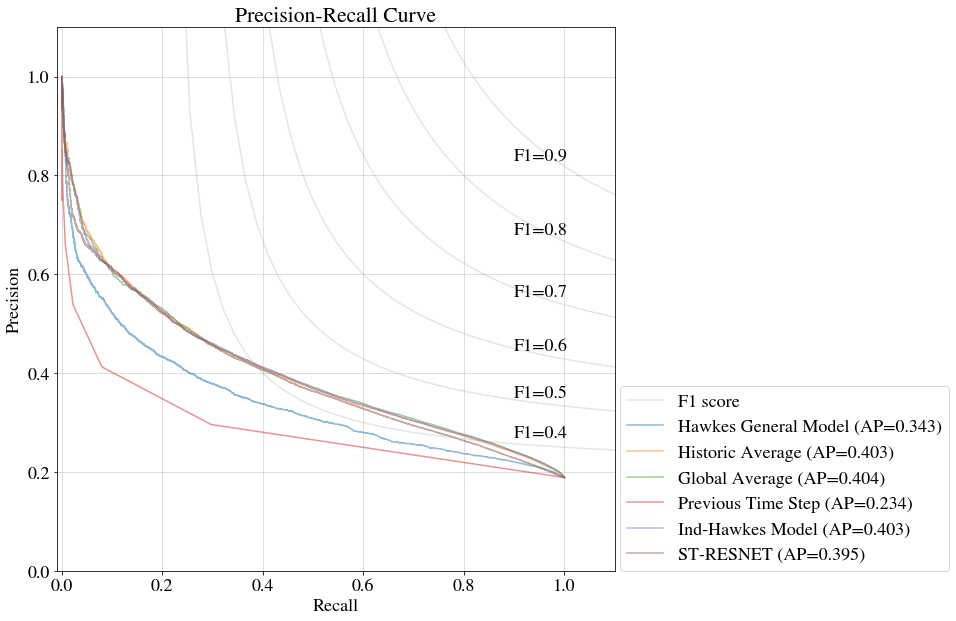

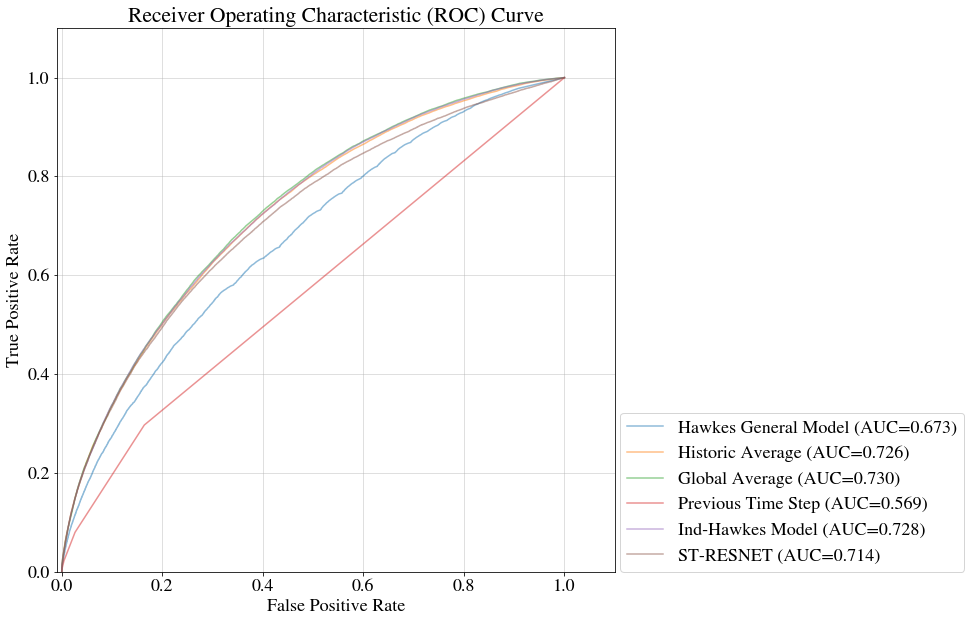

2019-11-12T10:18:47 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:18:47 | root | INFO | Device: cuda:0
2019-11-12T10:18:47 | root | INFO | 	t_range shape (731,)
2019-11-12T10:18:48 | root | INFO | lr: 		0.0005
2019-11-12T10:18:48 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:18:48 | root | INFO | 
 ====================== Training ST-RESNET-Extra ====================== 

2019-11-12T10:18:48 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET-Extra',
 'model_path': './data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/',
 'n_channels': 3,
 'n_layers': 5,
 'n_steps_c': 3,
 '

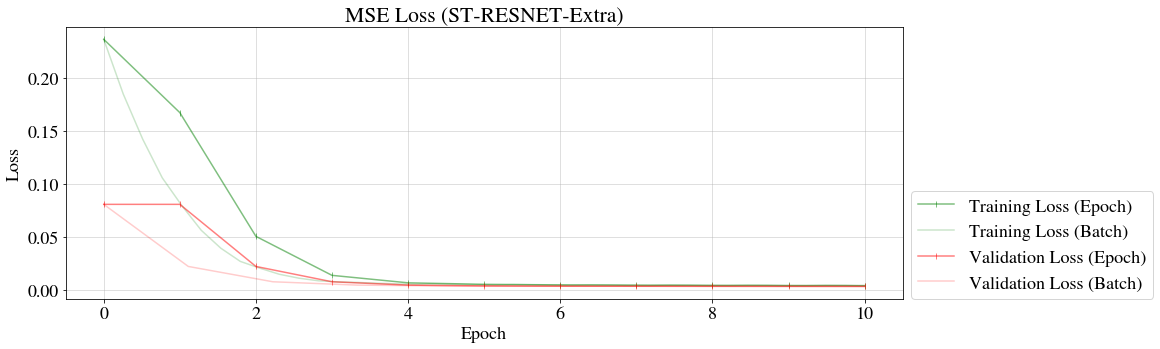

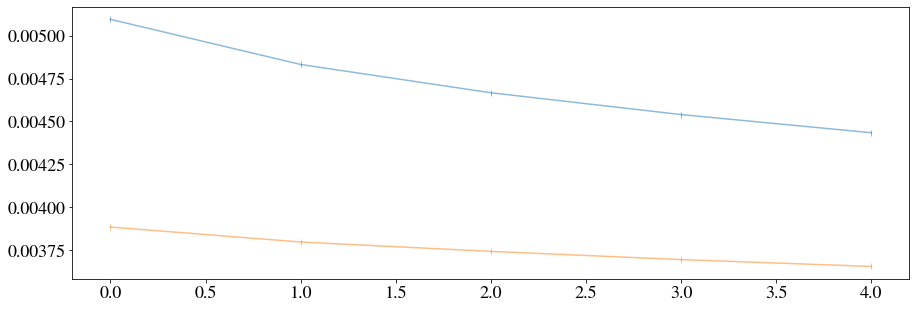

2019-11-12T10:19:42 | root | INFO | Loading model from checkpoint (best) for evaluation
2019-11-12T10:19:42 | root | INFO | loading model from ./data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/models/ST-RESNET-Extra/
2019-11-12T10:19:44 | root | INFO | f1_score: 0.45280371353867116 at index 752404, new threshold 0.018426155671477318
2019-11-12T10:19:46 | root | INFO | 
        MODEL METRICS
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7086900127336557                
                Average Precision:  0.39168274187318286
                Precision:          0.31612963656800297
                Recall:             0.6283892289431424
                Accuracy:           0.6733640755379886
                MCC:                0.25232053810445687          
        
2019-11-12T10:19:46 | root | INFO | 
        MODEL RESULT
            Model Name: ST-RESNET-Extra
                ROC AUC:            0.7086900127336557
                Average Precision:  0.3

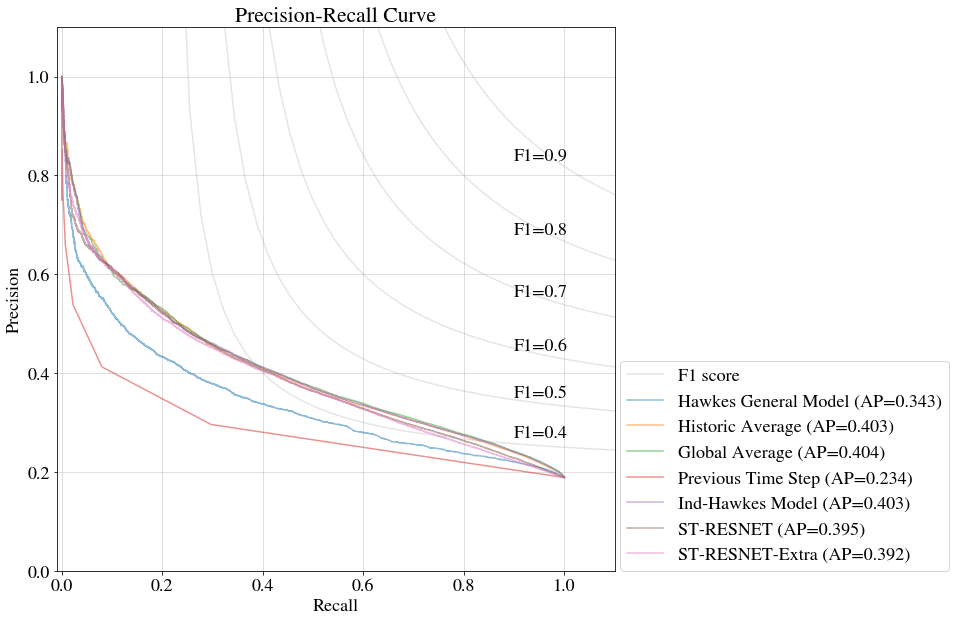

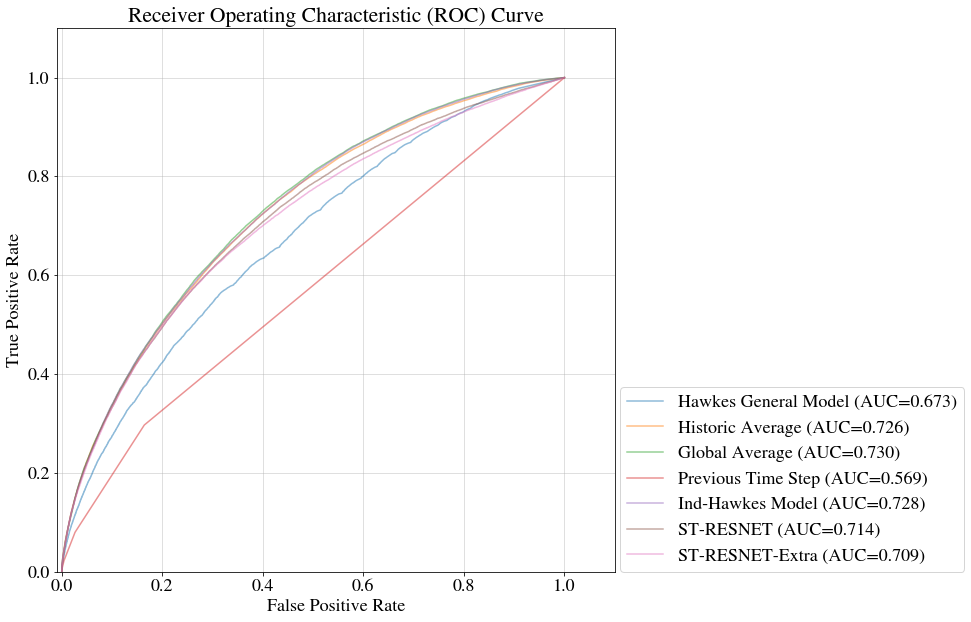

2019-11-12T10:19:51 | root | INFO | 
========================= T24H-X255M-Y220M_2013-01-01_2015-01-01 =========================

2019-11-12T10:19:51 | root | INFO | =====================================BEGIN=====================================
2019-11-12T10:19:51 | root | INFO | Device: cuda:0
2019-11-12T10:19:52 | root | INFO | 	t_range shape (731,)
2019-11-12T10:19:58 | root | INFO | lr: 		0.0005
2019-11-12T10:19:58 | root | INFO | weight_decay: 	1e-08
2019-11-12T10:19:58 | root | INFO | 
 ====================== Training ST-RESNET ====================== 

2019-11-12T10:19:58 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 64,
 'checkpoint': 'best',
 'data_path': './data/processed/T24H-X255M-Y220M_2013-01-01_2015-01-01/',
 'device': device(type='cuda', index=0),
 'dropout': 0,
 'early_stopping': False,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.0005,
 'max_epochs': 10,
 'model_name': 'ST-RESNET',
 'model_path': './data/processed/T

RuntimeError: ignored

In [10]:
for data_sub_path in data_sub_paths:
    log.info(f"\n========================= {data_sub_path} =========================\n")    
    for USE_EXTRA in [False, True]:
        
        conf = BaseConf()
        if USE_EXTRA:
            conf.model_name = "ST-RESNET-Extra"  # needs to be created
        else:     
            conf.model_name = "ST-RESNET"  # needs to be created

        conf.data_path = f"./data/processed/{data_sub_path}/"

        if not os.path.exists(conf.data_path):
            raise Exception(f"Directory ({conf.data_path}) needs to exist.")

        conf.model_path =  f"{conf.data_path}models/{conf.model_name}/"
        os.makedirs(conf.data_path, exist_ok=True)
        os.makedirs(conf.model_path, exist_ok=True)

        # logging config is set globally thus we only need to call this in this file
        # imported function logs will follow the configuration
        setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
        log.info("=====================================BEGIN=====================================")

        info = deepcopy(conf.__dict__)
        info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

        # DATA LOADER SETUP
        np.random.seed(conf.seed)
        use_cuda = torch.cuda.is_available()
        if use_cuda:
            torch.cuda.manual_seed( conf.seed)
        else:
            torch.manual_seed(conf.seed)

        device = torch.device("cuda:0" if use_cuda else "cpu")
        log.info(f"Device: {device}")
        info["device"] = device.type
        conf.device = device

        conf.batch_size = 64

        # CRIME DATA
        data_group = GridDataGroup(data_path=conf.data_path,
                                conf=conf)

        loaders = GridDataLoaders(data_group=data_group,
                                conf=conf)

        # SET THE HYPER PARAMETERS
        conf.dropout = 0#0.2
        conf.weight_decay = 1e-8
        conf.lr = 5e-4
        conf.checkpoint =  "best" # "latest" # 
        conf.resume = False
        conf.freqstr = data_group.t_range.freqstr  
        conf.early_stopping = False
        conf.max_epochs = 10

        # SET LOSS FUNCTION
        # size averaged - so more epochs or larger lr for smaller batches
        loss_function = nn.MSELoss()  

        # SETUP MODEL
        dataset = loaders.train_loader.dataset
        _, h_size, w_size = dataset.crimes.shape
        _, n_ext_features = dataset.time_vectors.shape


        # todo setup - hyper-optimiser
        conf.n_layers = 5  # number of res-unit layers
        conf.n_channels = 3 # inner channel size of the res-units 

        if USE_EXTRA:
            train_epoch_fn = train_epoch_for_st_res_net_extra
            evaluate_fn = evaluate_st_res_net_extra
            model = STResNetExtra(n_layers=conf.n_layers,
                                n_channels=conf.n_channels,
                                y_size=h_size,
                                x_size=w_size,

                                lc=dataset.n_steps_c,
                                lp=dataset.n_steps_p,
                                lq=dataset.n_steps_q,

                                n_ext_features=n_ext_features,
                                n_demog_features=37,
                                n_demog_channels=10,
                                n_demog_layers=3,

                                n_gsv_features=512,
                                n_gsv_channels=10,
                                n_gsv_layers=3)
        else:
            train_epoch_fn = train_epoch_for_st_res_net
            evaluate_fn = evaluate_st_res_net
            model = STResNet(n_layers=conf.n_layers,
                            n_channels=conf.n_channels,
                            y_size=h_size,
                            x_size=w_size,

                            lc=dataset.n_steps_c,
                            lp=dataset.n_steps_p,
                            lq=dataset.n_steps_q,

                            n_ext_features=n_ext_features)    
            
        # todo implement model_arch for res-net
        model.to(conf.device)

        # SETUP OPTIMISER
        parameters = model.parameters()
        # todo (optional): setup model parameters dynamically 

        optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

        if conf.resume:
            try:
                # resume from previous check point or resume from best validaton score checkpoint
                # load model state
                model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                            map_location=conf.device.type)
                model.load_state_dict(model_state_dict)
                
                # load optimiser state
                optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                                map_location=conf.device.type)
                optimiser.load_state_dict(optimiser_state_dict) 

                # new optimiser hyper-parameters
                optimiser.param_groups[0]['lr'] = conf.lr
                optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

            except Exception as e:
                log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")


        log.info(f"lr: \t\t{optimiser.param_groups[0]['lr']}")
        log.info(f"weight_decay: \t{optimiser.param_groups[0]['weight_decay']}")
        trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                                optimiser=optimiser,
                                                loaders=loaders,
                                                train_epoch_fn=train_epoch_fn,
                                                loss_fn=loss_function,
                                                conf=conf)    

        print(f"stopped_early: {stopped_early}") # use the current epoch instead
        # if stopped_early -> continue with best_model - new hyper-parameters -> no n 

        plt.figure(figsize=(15,5))
        for x in [trn_epoch_losses, val_epoch_losses]:
            plt.plot(x[-5:],marker='|',alpha=.5)
        plt.show()

        # Load latest or best validation model
        # conf.checkpoint = "latest"
        conf.checkpoint = "best"

        log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        log.info(f"loading model from {conf.model_path}")
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                        map_location=conf.device.type)
        model.load_state_dict(model_state_dict)

        trn_y_counts, trn_y_true, trn_probas_pred, trn_t_range = evaluate_fn(model=model,
                                                                            batch_loader=loaders.train_loader,
                                                                            conf=conf) 
        thresh = best_threshold(trn_y_true, trn_probas_pred) 

        tst_y_counts, tst_y_true, tst_probas_pred, tst_t_range = evaluate_fn(model=model,
                                                                            batch_loader=loaders.test_loader,
                                                                            conf=conf)


        tst_y_true = np.expand_dims(tst_y_true, axis=1)
        tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1) 

        tst_y_true = data_group.shaper.squeeze(tst_y_true)
        tst_probas_pred = data_group.shaper.squeeze(tst_probas_pred)


        tst_y_pred = get_y_pred(thresh, tst_probas_pred)
        save_metrics(y_true=tst_y_true,
                    y_pred=tst_y_pred,
                    probas_pred=tst_probas_pred,
                    t_range=tst_t_range,
                    shaper=data_group.shaper,                
                    conf=conf)
        compare_models(data_path=conf.data_path)

In [0]:
for data_sub_path in get_data_sub_paths():
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    models_metrics = get_models_metrics(data_path)
    metrics_table = get_metrics_table(models_metrics)
    print(metrics_table)
    print("\n===================================================================================================\n")